# Joris Schefold (1042 1092)
## Final assignment: an X-ray source safari
This document consists of a couple of parts that will be outlined here in short. The first part contains most of the standard functions (such as a histrebin function) as well as the models. Then in the second part the data is loaded and prepared for te model fitting. Finally the model fitting takes place in three distinct steps:
In the first step the compuationally "simple" models, "ULX1", "ULX2", "power", "XRB", ("power" is a simple power law) are fitted. Then, in the cases where the fit can be improved, by freeing up emission lines, the other models are fitted. In the final fit step extra emission/absorbtion lines visible in the residuals of step 2 are fitted.
After the data is fitted the best models are presented.


In [1]:
import numpy as np
import scipy.stats
import scipy.optimize as op
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import pandas as pd
import seaborn as sns
import random as rand
import os
import collections
import itertools


# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

print "Required modules loaded \n\n" 

Required modules loaded 




In [2]:
###
### Create a class to hold and store the data 
###

class StellarObject:
    def __init__(self, name, data):
        self.name = name
        self.data = data
        self.edges = []
        self.density = []
        self.densityError = []
        self.normDenisty = []
        self.normDensityError = []
        self.binsize = []
        self.results = {}
        


###
### Here we define some functions that are needed for the rest of the data analyses.
###

# Rebin a histogram so there are at least a certain amount of counts per bin (mininbin).
def histrebin(mininbin, counts, edges):
    counts2, edges2 = np.zeros(1), np.zeros(1)
    i, countsum, firstbin_flag = 0, 0, 1
    edges2[0] = edges[0]

    for x in counts:
        countsum = countsum + x
        i = i + 1
        # The sum over counts in remaining bins ensures that no bins
        # with counts less than our limit at the end are obtained.
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):
            # If this is the first bin satisfying the requirement,
            # do not append but replace bin 0 with countsum instead.
            if firstbin_flag == 1:
                counts2[0] = countsum
                # Now that the first bin was read this can be switched off.
                firstbin_flag = 0
            else:
                counts2=np.append(counts2, countsum)

            edges2 = np.append(edges2, edges[i])
            countsum = 0        

    return counts2, edges2



###
### define our functional models
###

def add_emmision_line(E, lineNormalisation, lineEnergie):
    sigma = 0.06*np.sqrt(lineEnergie)
    return scipy.stats.norm.pdf(E, lineEnergie, sigma)*lineNormalisation


def model_ULX1(parm, E): 
    def func(E):
        if E <= Ebk:
            return N0 * (E)**(-Gamma1)
        else:
            return N0 * (Ebk)**(-Gamma1) * (E / Ebk)**(-Gamma2)
    N0 = parm[0]
    Ebk = parm[1]
    Gamma1 = parm[2]
    Gamma2 = parm[3]
    if not np.iterable(E):
        return func(E)
    else:
        return [func(indivE) for indivE in E]


def model_ULX2(parm, EList):
    def func(E):
        return N0 * (E)**(-Gamma) * np.exp(-E / Ecut)
        
    N0 = parm[0]
    Ecut = parm[1]
    Gamma = parm[2]
    return func(EList)

    
def model_SNR(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    Si13Strength = parm[2]
    Si15Strength = parm[3]
    FeStrength = parm[4]

    return func(EList) + add_emmision_line(EList, Si13Strength, 1.83) + \
add_emmision_line(EList, Si15Strength, 2.4) + add_emmision_line(EList, FeStrength, 6.7)


def model_XRB(parm, EList):
    def func(E):
            return N0 * (E)**(2) / ( np.exp(E / KbT) - 1)
        
    N0 = parm[0]
    KbT = parm[1]
    return func(EList)


def model_AGN1(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    return func(EList)


def model_power(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    return func(EList)


def model_AGN2(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    FeStrength = parm[2]
    return func(EList) + add_emmision_line(EList, FeStrength, 6.7)


def extraLines(lines, EValueOrList):
    if np.iterable(EValueOrList):
        E = np.zeros[len(EValueOrList)]
    else:
        E = 0
        
    for i in range(len(lines)/2):
        E += add_emmision_line(EValueOrList, lines[2*i], lines[2*i+1])
    return E


def ChiSq_Integ(parm, ebins, yval, dy, source, NLines=None): # the weighted least-squares for an array of upper and lower bin edges
    # (xval1 and xval2) fitted with the integral over the bin of the generic model my_fit_model
    i = 0
    ymod = np.zeros(len(yval))
    model = eval("model_"+source)
    for energy in ebins[:-1]:
        if NLines:
            ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x) + extraLines(parm[-2*NLines:], x), ebins[i],ebins[i+1])
        else:
            ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1

    return sum(pow((yval-ymod)/dy,2))


def LogLikelihood_Pois_Integ(parm, ebins, yval, source, NLines=None): # the -ve log-likelihood or an array of bin edges, fitted with 
    # the integral over the bin of the generic model my_fit_model.  Input yval must be counts and not counts per
    # unit x-value
    i = 0
    ymod = np.zeros(len(yval))
    model = eval("model_"+source)

    for energy in ebins[:-1]:
        if NLines:
                ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x) + extraLines(parm[-2*NLines:], x), ebins[i],ebins[i+1])
        else:
            ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be counts per bin
        i=i+1
        
    pd = scipy.stats.poisson(ymod) #we define our Poisson distribution
    return -sum(np.log(pd.pmf(yval)))


def printParmError(parm, error, model):
    if("ULX1" in model):
        print "N0: {} +/- {}\nEbk: {} +/- {}\nGamma1: {} +/- {}\nGamma2: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[2], error[2], parm[3], error[3])
    
    elif( "ULX2" in model):
        print "N0: {} +/- {}\nEcut: {} +/- {}\nGamma: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[2], error[2])
    
    elif( "SNR" in model):
        print "N0: {} +/- {}\Gamma: {} +/- {}\nSi13Strength(at 1.83keV): {} +/- {}\nSi15Strength (at 2.4keV): {} +/- {}\nFeStrength (at 6.7keV): {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[2], error[2], parm[3], error[3], parm[4], error[4])
        
    elif( "XRB" in model):
        print "N0: {} +/- {}\nKbT: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1])
       
    elif( "AGN1" in model):
        print "N0: {} +/- {}\nGamma: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1])
        
    elif( "AGN2" in model):
        print "N0: {} +/- {}\nGamma: {} +/- {}\nFeStrength (at 6.4keV): {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1], parm[1], error[1])
        
    elif( "power" in model):
        print "N0: {} +/- {}\nGamma: {} +/- {}\n".format(
        parm[0], error[0], parm[1], error[1])
    
    if "1spectralLines" in model:
        print "spectral line at: {} +- {} with intensity {} +- {}\n".format(parm[0], error[0], parm[1], error[1])
    elif "2spectralLines" in model:
        print "spectral line at: {} +- {} with intensity {} +- {}\nspectral line at: {} +- {} with intensity {} +- {}\n\
        ".format(parm[0], error[0], parm[1], error[1], parm[2], error[2], parm[3], error[3])
    elif "3spectralLines" in model:
        print "spectral line at: {} +- {} with intensity {} +- {}\nspectral line at: {} +- {} with intensity {} +- {}\nspectral \
        line at: {} +- {} with intensity {} +- {}".format(parm[0], error[0], parm[1], error[1], parm[2], error[2], \
                                                          parm[3], error[3], parm[4], error[4], parm[5], error[5])


def plotFitResiduals(stellarObject, models, possibleAbsorbtionLines=[], possibleEmissionLines=[]):
    ###
    ### Make a plot of the data with the model and residual(s) in a subplot
    ###
    f, axes = plt.subplots(len(models)+1, figsize=(9,6 * (len(models)+1)))
    axes[0].errorbar(stellarObject.centres, stellarObject.density, xerr=stellarObject.binsize/2,
                     yerr=stellarObject.densityError, fmt="o", label="Data")
    
    ###
    ### Create plot of original graphs
    ###
    axes[0].set_xlabel("Energy (keV)")
    axes[0].set_ylabel("Flux density")
    axes[0].set_title("Fit of models {} on {}".format(models, stellarObject.name))
    
    
    ###
    ### Create the residual plots and the fits
    ###
    for i in range(len(models)):
        model = models[i]
        prediction = np.zeros(len(stellarObject.centres))
        parameters = stellarObject.results[models[i]]["x"]
        if "1spectralLines" in model:
            prediction += add_emmision_line(stellarObject.centres, parameters[-2], parameters[-1])
        elif "2spectralLines" in model:
            prediction += add_emmision_line(stellarObject.centres, parameters[-2], parameters[-1]) +\
            add_emmision_line(stellarObject.centres, parameters[-4], parameters[-3])
        elif "3spectralLines" in model:
                prediction += add_emmision_line(stellarObject.centres, parameters[-2], parameters[-1]) + \
                add_emmision_line(stellarObject.centres, parameters[-4], parameters[-3]) + \
                add_emmision_line(stellarObject.centres, parameters[-6], parameters[-5])
        
        
        if "spectralLines" in model:
            predictionStandard = eval("model_" + model[:-14])(parameters, stellarObject.centres)
            prediction += predictionStandard
        else:
            prediction = eval("model_" + model)(parameters, stellarObject.centres)
        
        axes[0].plot(stellarObject.centres, prediction, label=models[i])
        axes[0].plot(stellarObject.centres, predictionStandard, label=models[i])


        residual = stellarObject.density - prediction
        residual /= stellarObject.densityError
        
        axes[i+1].errorbar(stellarObject.centres, residual, xerr=stellarObject.binsize/2, yerr=1, fmt="o")
        axes[i+1].set_xlabel("Energy (keV)")
        axes[i+1].set_ylabel("Standard errors")
        axes[i+1].set_title("Residuals  of model {}, average = {} stdv".format(models[i], np.average(residual)))
        axes[i+1].axhline(0.0, color='r', linestyle='dotted', lw=2)

    ###
    ### Create the grid and possible emission lines
    ###
    for ax in axes:
        ax.patch.set_facecolor('0.8')
        ax.grid(True, color='w', linestyle='-', linewidth=1)    
        for emissionLine in possibleEmissionLines:
            ax.axvline(emissionLine, color='r', linestyle='dotted', lw=2)

        for absorbtionLine in possibleAbsorbtionLines:
            ax.axvline(absorbtionLine, color='g', linestyle='dotted', lw=2)
        
    f.set_tight_layout(True)
    axes[0].legend()

print "Classes, constants and functions loaded \n"

Classes, constants and functions loaded 



# Loading and prepping the data

In [3]:
data = np.genfromtxt("Schefold_energies.txt", dtype=float, skip_header=0, autostrip=True, names=["Object#", "Flux"])

sources = {i:[] for i in range(1,11)}
for source, dataPoint in data:
    sources[source].append(dataPoint)
    
stellarObjects = [StellarObject("StellarObject #{}".format(i), sources[i]) for i in range(1, 11)]

print "Data loaded \n"

Data loaded 



In [4]:
# edgesDict, densityDict, errorDict, binsizeDict = {}, {}, {}, {}
minNCounts = 20 

###
### Bin and rebin the data
###
for stellarObject in stellarObjects:
    data = stellarObject.data
    counts, edges = np.histogram(data, bins=100, range=[np.min(data),np.max(data)], density=False)
    counts, edges = histrebin(minNCounts, counts, edges)

    assert len(counts) == len(counts[counts>=minNCounts])
    
    ###
    ### Calculate parameters it here is assumed that the errors are are Poissonian.
    ### Therefore the standard error on the counts in a bin is sqrt{n) where n is the number of counts 
    ###
    binsize = np.diff(edges) # calculates the width of each bin
    dens = counts/binsize # determines the count densities
    err = np.sqrt(counts)/binsize # calculate the errors: remember the error is based on the counts,         


    ###
    ### Save data and renormalize
    ###
    stellarObject.edges = edges
    stellarObject.centres = (edges[0:len(counts)] + edges[1:len(counts)+1])/2
    stellarObject.normDensity = dens/max(dens)
    stellarObject.normDensityError = err/max(dens)
    stellarObject.density = dens
    stellarObject.densityError = err
    stellarObject.binsize = binsize
    stellarObject.counts = counts


print "Data processed"

Data processed


Exploratory data plot


C:\Users\joris\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


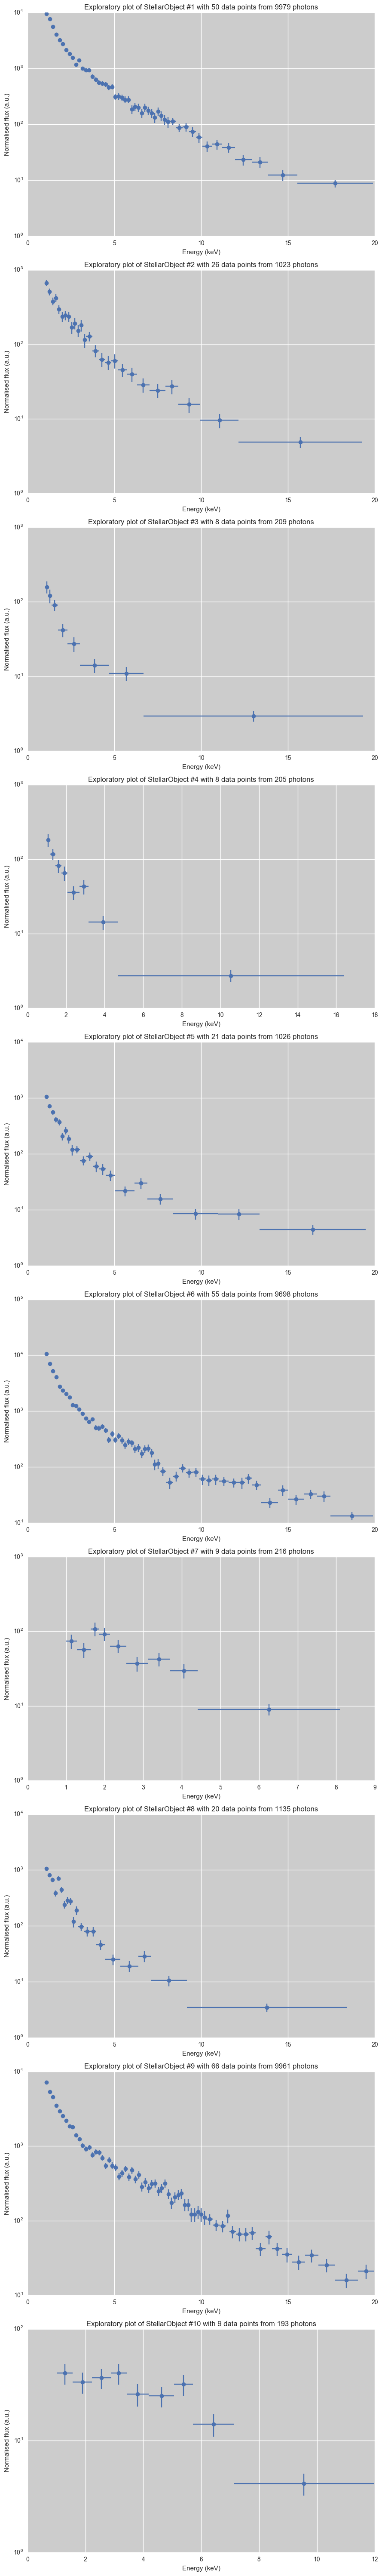

In [5]:
print "Exploratory data plot"
NStellerObjects = len(stellarObjects)
f, axes = plt.subplots(NStellerObjects, 1, figsize=(9, 6*NStellerObjects))
for i in range(NStellerObjects):
    ax = axes[i]
    stellarObject = stellarObjects[i]
    
    ###
    ### Make the plot
    ###
    ax.errorbar(stellarObject.centres, stellarObject.density, xerr=stellarObject.binsize/2,
                 yerr=stellarObject.densityError, fmt="o", label="Data")
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Normalised flux (a.u.)")
    ax.set_title("Exploratory plot of {} with {} data points from {} photons".format(stellarObject.name, len(stellarObject.density), len(stellarObject.data)))
    ax.patch.set_facecolor('0.8')
    ax.grid(True, color='w', linestyle='-', linewidth=1)
    ax.set_yscale('log')
       
    
f.set_tight_layout(True)
plt.show()

# Fitting the data


In [7]:
sourceList = ["ULX1", "ULX2", "power", "XRB"]
# sourceList = ["XRB"]

colorsList = itertools.cycle(cm.rainbow(np.linspace(0, 1, len(sourceList))))

for stellarObject in stellarObjects:
    startingHeight = stellarObject.density[0]
    stellarObject.startingParamDict = {"ULX1":[1, 7, 1.8, 2.8], \
                         "ULX2":[startingHeight, 8.8, 2], \
                         "SNR":[startingHeight, 2.5, .1, .1, .01], \
                         "XRB":[startingHeight, 1.4], \
                         "AGN1":[startingHeight, 2.2], \
                         "AGN2":[startingHeight, 1.6, .3],\
                          "power":[startingHeight, 3]}

    stellarObject.boundDict = {"ULX1": [(startingHeight/3, None), (5, 10), (1.4, 2.2), (2.4, 3.2)], \
                "ULX2":[(startingHeight/3, None), (4, 10), (1.5, 3.2)], \
                 "SNR":[(startingHeight/3, None), (2.2, 2.9), (0, None), (0, None), (0, None)], \
                 "XRB":[(startingHeight/3, None), (.6, 1.6)], \
                 "AGN1":[(startingHeight/3, None), (2, 2.7)], \
                 "AGN2":[(startingHeight/3, None), (1.5, 2.2), (0, None)],\
                "power":[(startingHeight/3, None), (1.5, 3)]}

print "Fitting constants created"

Fitting constants created


Starting annalysis fase 1



===========================StellarObject #1   (9979 data points)===========================
SNR
Minimum Chi-squared: 196.913750226 for 45 d.o.f.
The goodness of fit is: 6.66651563934e-21
Parameters:  [  1.30479875e+04   2.32052311e+00   2.83606284e+01   5.05523968e+01
   1.26631442e+01]
Took 71 evaluations

AGN1
Minimum Chi-squared: 202.159583555 for 48 d.o.f.
The goodness of fit is: 8.07107041511e-21
Parameters:  [  1.31298457e+04   2.31678505e+00]
Took 30 evaluations

AGN2
Minimum Chi-squared: 279.917991131 for 47 d.o.f.
The goodness of fit is: 7.04286315802e-35
Parameters:  [  1.19696579e+04   2.20000000e+00   0.00000000e+00]
Took 36 evaluations




===========================StellarObject #2   (1023 data points)===========================
SNR
Minimum Chi-squared: 108.760389445 for 21 d.o.f.
The goodness of fit is: 7.88453082617e-14
Parameters:  [ 1088.18367149     2.2            2.18981023    22.14523237     9.11111864]
Took 41 evaluations

AGN1
Minimum

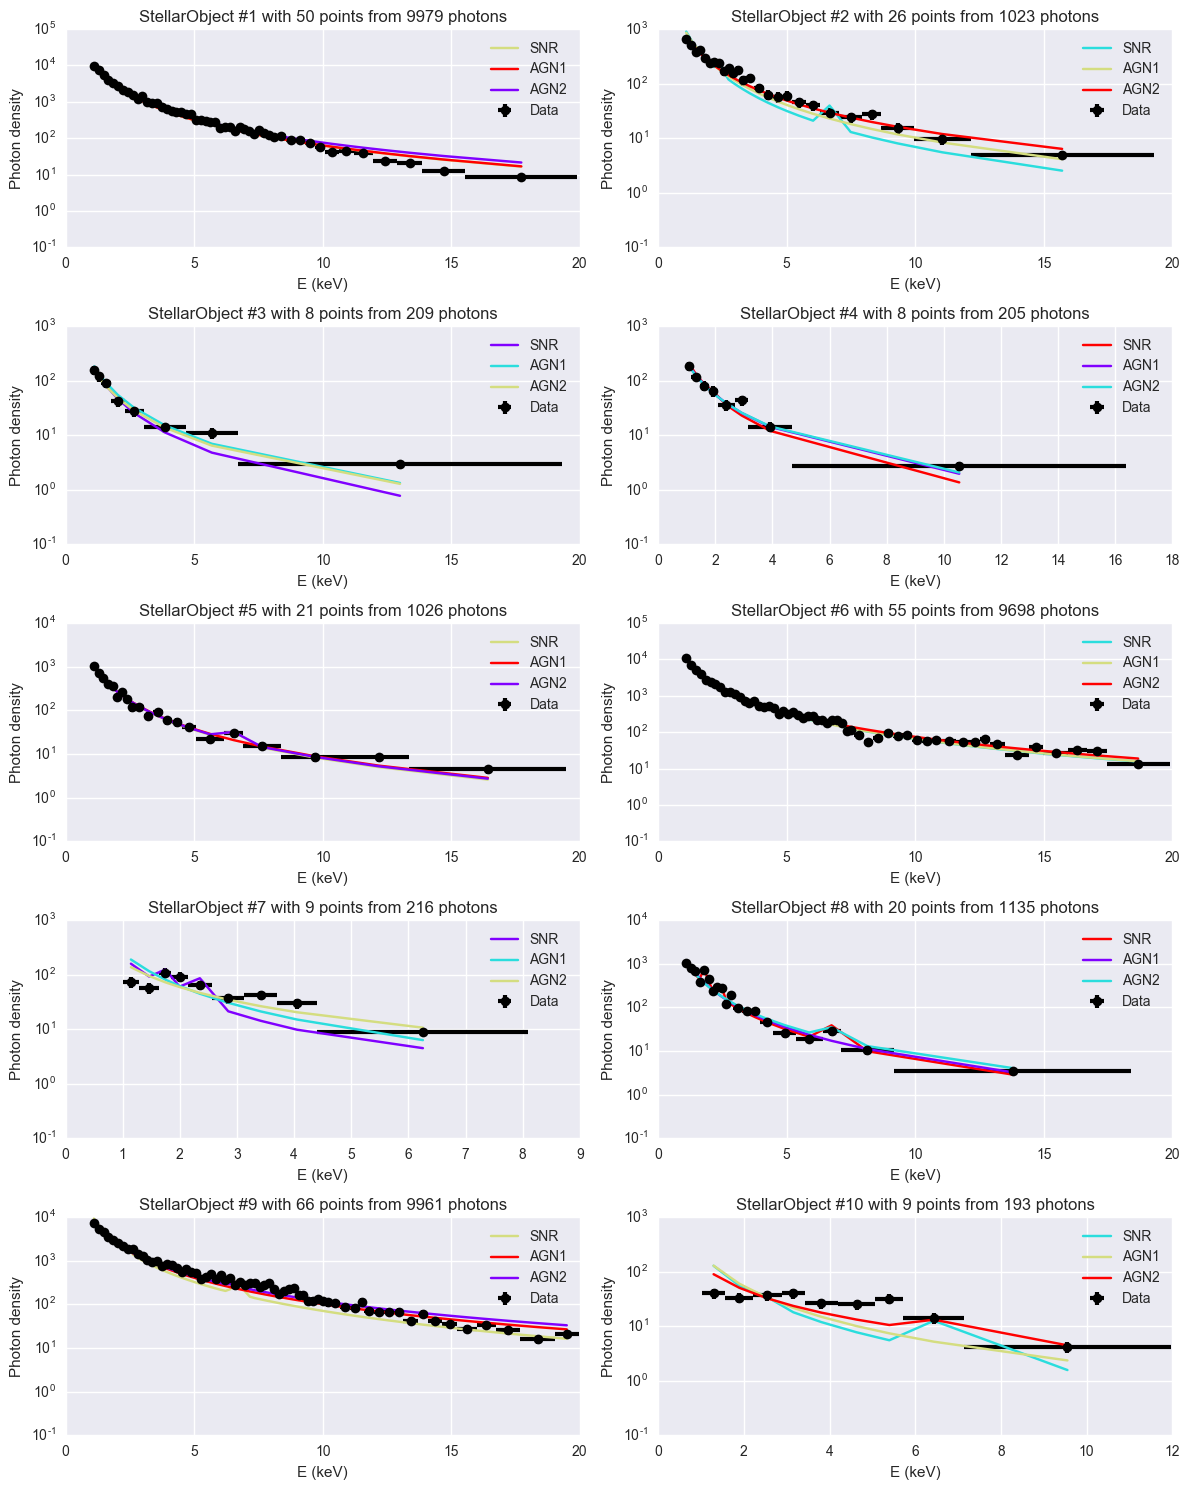

Analyses fase 1 complete


In [15]:
###
### In this fase the models: ["ULX1", "ULX2", "power", "XRB"] are fitted to the data
###
print "Starting annalysis fase 1"


f, axes = plt.subplots(5,2,figsize=(12,15))

for i in range(5):
    for j in range(2):
        ax = axes[i][j]
        k = 2 * i + j
        stellarObject = stellarObjects[k]
        
        print "\n\n\n==========================={}   ({} data points)===========================".format(
            stellarObject.name, len(stellarObject.data))
        
        for source in sourceList:
            startingParm = stellarObject.startingParamDict[source]
            specificBounds = stellarObject.boundDict[source]

            if len(stellarObject.data) > 1000:
                result = op.minimize(ChiSq_Integ, startingParm, args=(stellarObject.edges, stellarObject.density, 
                                                                      stellarObject.densityError, source),
                                     bounds=specificBounds, options={"maxiter":100})            
            else:
                result = op.minimize(LogLikelihood_Pois_Integ, startingParm, args=(stellarObject.edges, stellarObject.counts, source),
                                     bounds=specificBounds, options={"maxiter":100})            
                

            ###
            ### Get usefull info from the fit such as pval and used parameters
            ### Save the result
            ###
            ml_vals = result["x"]
            ml_func = result["fun"]
            stellarObject.results[source] = result
        
            ###
            ### Plot the fits
            ###
            xList = stellarObject.centres
            yList = [eval("model_"+source)(ml_vals, x) for x in xList]         
#             ax.plot(xList, yList, linestyle="steps-mid", color=next(colorsList), label=source)
            ax.plot(xList, yList, color=next(colorsList), label=source)
            
            
            ###
            ### Output results
            ###
            pval = scipy.stats.chi2.sf(ml_func, df=len(stellarObject.density) - len(startingParm))
            print source
            print "Minimum Chi-squared: {} for {} d.o.f.".format(ml_func,len(stellarObject.density)-len(startingParm))
            print "The goodness of fit is: {}".format(pval)
            print "Parameters: ", ml_vals
            print "Took {} evaluations".format(result["nit"])
            if pval>0.001:
                print "<====================== possible fit"
            print ""

        ###    
        ### Plot original 
        ###
#         ax.errorbar(stellarObject.centres, stellarObject.normDensity, xerr=stellarObject.binsize/2., 
#                     yerr=stellarObject.normDensityError, lw=3, color="k", label="Data", fmt="o")

        ax.errorbar(stellarObject.centres, stellarObject.density, xerr=stellarObject.binsize/2., 
                    yerr=stellarObject.densityError, lw=3, color="k", label="Data", fmt="o")

        ax.set_yscale('log')
        ax.set_ybound([10**(-1),None])
        ax.set_ylabel("Photon density")
        ax.set_xlabel("E (keV)")
        ax.set_title("{} with {} points from {} photons".format(stellarObject.name, len(stellarObject.centres), len(stellarObject.data)))
        ax.legend()
f.set_tight_layout(True)        
plt.show()
print "Analyses fase 1 complete"

In [24]:
print "Starting fase 2 of analyses"
###
### In this fase the models ["SNR", "AGN1", "AGN2"] are fitted to the the entries that still need a good fit
###
sourceList = ["SNR", "AGN1", "AGN2"]
for stellarObject in stellarObjects:
    bestFit = np.inf
    
    ###
    ### Find wich of the models fits te data the best.
    ###
    for model in stellarObject.results.keys():
        result = stellarObject.results[model]

        if result["fun"] < bestFit:
            bestFit = result["fun"]
            stellarObject.bestFittingModel = model
            
    pvalBestFittingModel = scipy.stats.chi2.sf(bestFit, df=len(stellarObject.density) - len(stellarObject.results[stellarObject.bestFittingModel]["x"]))
    if pvalBestFittingModel < 0.001 or stellarObject.bestFittingModel == "power":        
        print "\n\n\n==========================={}   ({} data points)===========================".format(
            stellarObject.name, len(stellarObject.data))
        
        for source in sourceList:
            startingParm = stellarObject.startingParamDict[source]
            specificBounds = stellarObject.boundDict[source]

            if len(stellarObject.data) > 1000:
                result = op.minimize(ChiSq_Integ, startingParm, args=(stellarObject.edges, stellarObject.density, 
                                                                      stellarObject.densityError, source),
                                     bounds=specificBounds, options={"maxiter":100})            
            else:
                result = op.minimize(LogLikelihood_Pois_Integ, startingParm, args=(stellarObject.edges, stellarObject.counts, source),
                                     bounds=specificBounds, options={"maxiter":100})            
                

            ###
            ### Get usefull info from the fit such as pval and used parameters
            ### Save the result
            ###
            ml_vals = result["x"]
            ml_func = result["fun"]
            stellarObject.results[source] = result

            if result["fun"] < bestFit:
                bestFit = result["fun"]
                stellarObject.bestFittingModel = model        
           
            ###
            ### Output results
            ###
            pval = scipy.stats.chi2.sf(ml_func, df=len(stellarObject.density) - len(startingParm))
            print source
            print "Minimum Chi-squared: {} for {} d.o.f.".format(ml_func,len(stellarObject.density)-len(startingParm))
            print "The goodness of fit is: {}".format(pval)
            print "Parameters: ", ml_vals
            print "Took {} evaluations".format(result["nit"])
            if pval>0.001:
                print "<====================== possible fit"
            print ""
            
            
    ###
    ### Power law was not an acutal model so we can remove it now
    ### We can also remove the worse fitting version of ULX1 vs ULX2 and AGN1 vs AGN 2
    ###
    if "power" in stellarObject.results.keys():
        del stellarObject.results["power"]
    
    if ('ULX1' in stellarObject.results.keys()) and ('ULX2' in stellarObject.results.keys()):
        pval1 = scipy.stats.chi2.sf(stellarObject.results["ULX1"]["fun"], df=len(stellarObject.density) - len(stellarObject.results["ULX1"]["x"]))
        pval2 = scipy.stats.chi2.sf(stellarObject.results["ULX2"]["fun"], df=len(stellarObject.density) - len(stellarObject.results["ULX2"]["x"]))
        if pval1 > pval2:
            del stellarObject.results["ULX2"]
        else:
            del stellarObject.results["ULX1"]
        
    if ('AGN1' in stellarObject.results.keys()) and ('AGN2' in stellarObject.results.keys()):        
        pval1 = scipy.stats.chi2.sf(stellarObject.results["AGN1"]["fun"], df=len(stellarObject.density) - len(stellarObject.results["AGN1"]["x"]))
        pval2 = scipy.stats.chi2.sf(stellarObject.results["AGN2"]["fun"], df=len(stellarObject.density) - len(stellarObject.results["AGN2"]["x"]))
        if pval1 > pval2:
            del stellarObject.results["AGN2"]
        else:
            del stellarObject.results["AGN1"]        

Starting fase 2 of analyses



===========================StellarObject #3   (209 data points)===========================
SNR
Minimum Chi-squared: 22.0225752654 for 3 d.o.f.
The goodness of fit is: 6.45293801961e-05
Parameters:  [ 219.17428276    2.2           0.            0.76262205   35.11012318]
Took 40 evaluations

AGN1
Minimum Chi-squared: 28.3028418257 for 6 d.o.f.
The goodness of fit is: 8.2391122377e-05
Parameters:  [ 225.06288871    2.        ]
Took 7 evaluations

AGN2
Minimum Chi-squared: 21.2684515658 for 5 d.o.f.
The goodness of fit is: 0.000720702105333
Parameters:  [ 190.73210874    1.94966541   23.967003  ]
Took 30 evaluations

8.2391122377e-05 0.000720702105333



===========================StellarObject #4   (205 data points)===========================
SNR
Minimum Chi-squared: 24.4771414394 for 3 d.o.f.
The goodness of fit is: 1.98582708104e-05
Parameters:  [ 242.86613962    2.2           2.2620416     0.            7.40777227]
Took 37 evaluations

AGN1
Minimum Chi-sq

## Intermezo
The preliminary results are printed and for each object the best fitting models are determined and plotted. 




===========================StellarObject #1   (9979 data points)===========================
XRB: 	 gof: 0.0000e+00 	 dof:48	 
AGN1: 	 gof: 8.0711e-21 	 dof:48	 
SNR: 	 gof: 6.6665e-21 	 dof:45	 
ULX2: 	 gof: 2.6910e-01 	 dof:47	 <=====



===========================StellarObject #2   (1023 data points)===========================
XRB: 	 gof: 4.0690e-27 	 dof:24	 
AGN1: 	 gof: 9.6528e-05 	 dof:24	 
SNR: 	 gof: 7.8845e-14 	 dof:21	 
ULX2: 	 gof: 3.5787e-01 	 dof:23	 <=====



===========================StellarObject #3   (209 data points)===========================
XRB: 	 gof: 1.4046e-14 	 dof:6	 
AGN2: 	 gof: 7.2070e-04 	 dof:5	 <=====
SNR: 	 gof: 6.4529e-05 	 dof:3	 
ULX2: 	 gof: 2.8120e-05 	 dof:5	 



===========================StellarObject #4   (205 data points)===========================
XRB: 	 gof: 5.6138e-08 	 dof:6	 
AGN1: 	 gof: 7.9528e-04 	 dof:6	 <=====
SNR: 	 gof: 1.9858e-05 	 dof:3	 
ULX2: 	 gof: 4.1985e-04 	 dof:5	 <=====



===========================StellarObject #5  

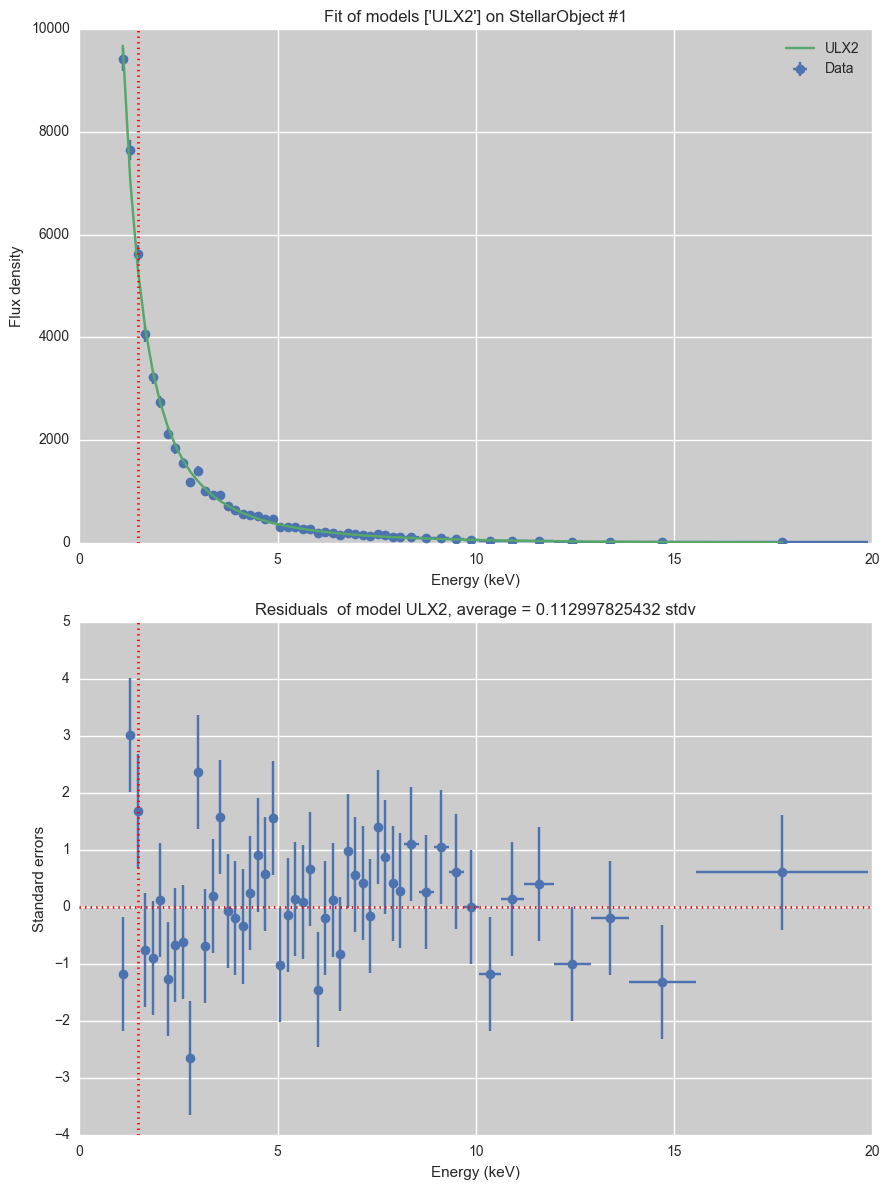

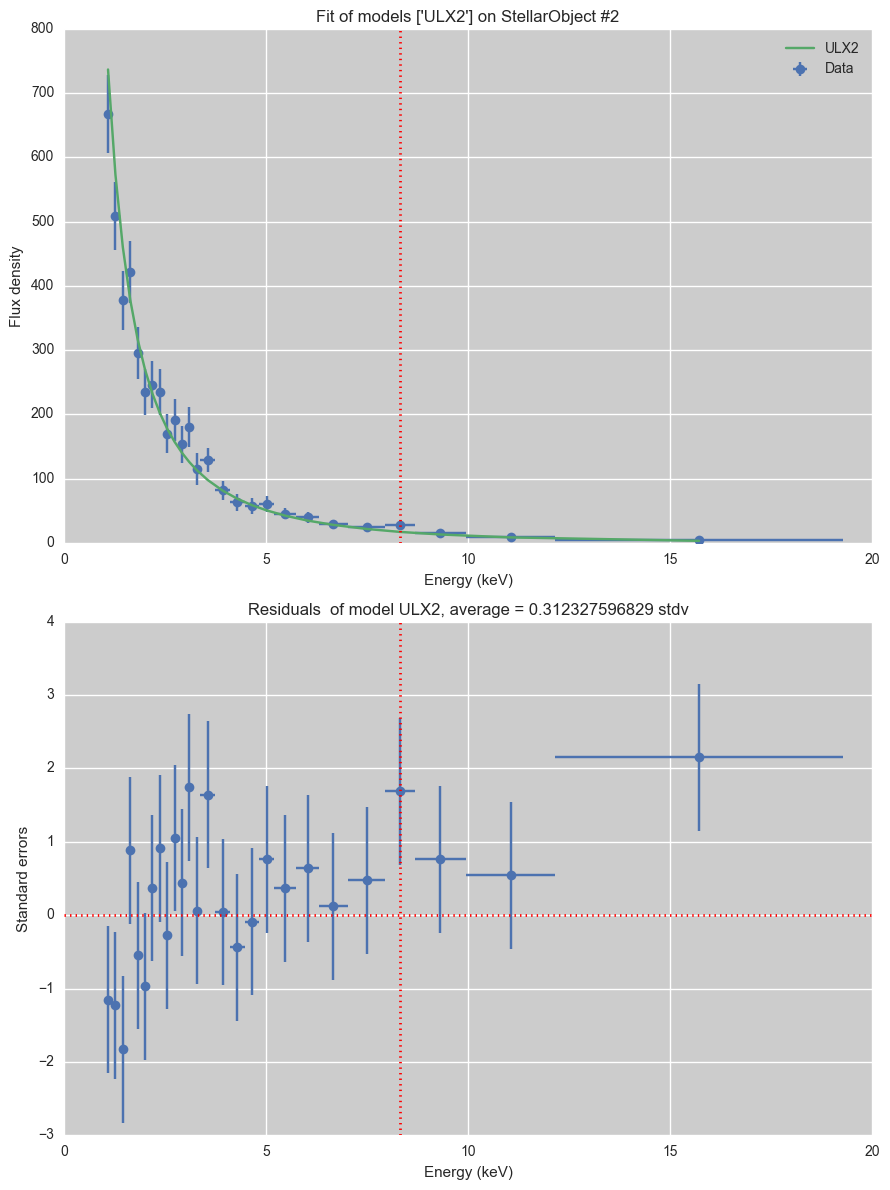

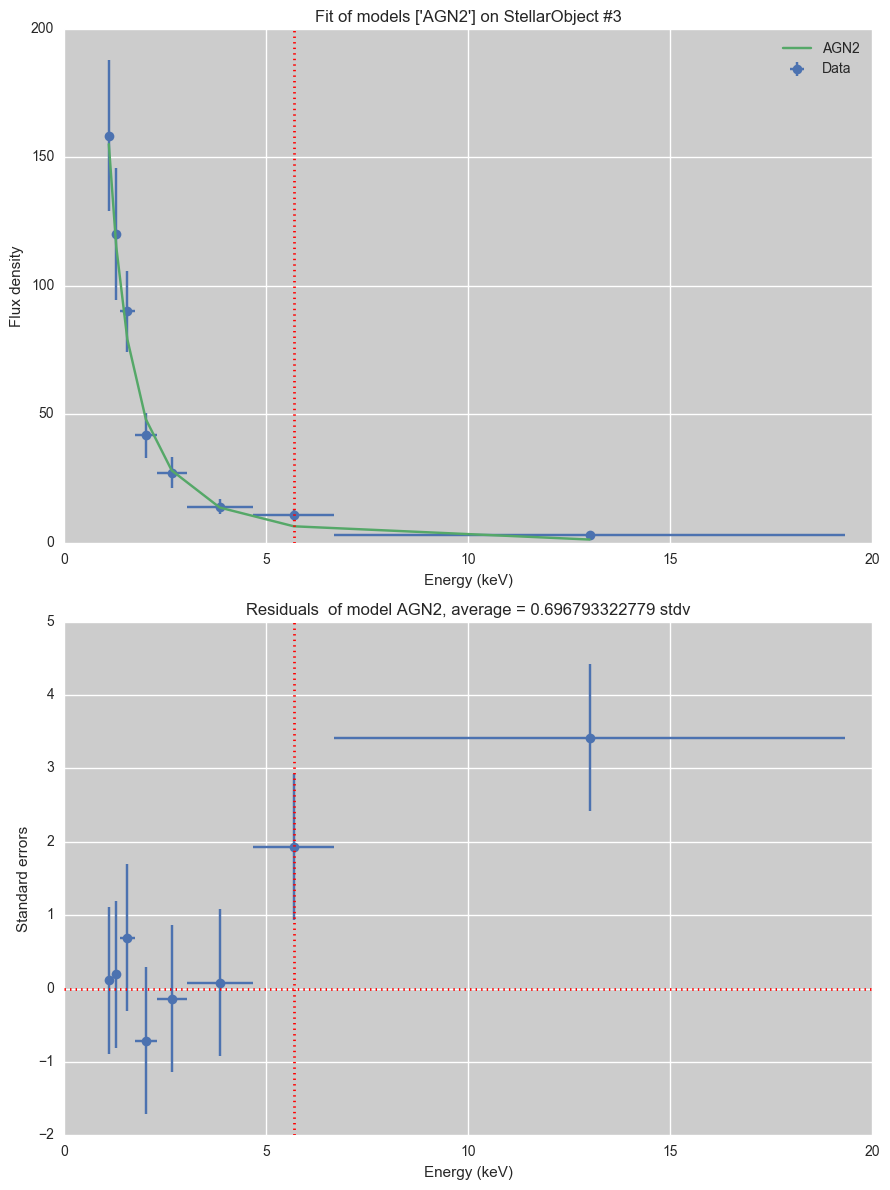

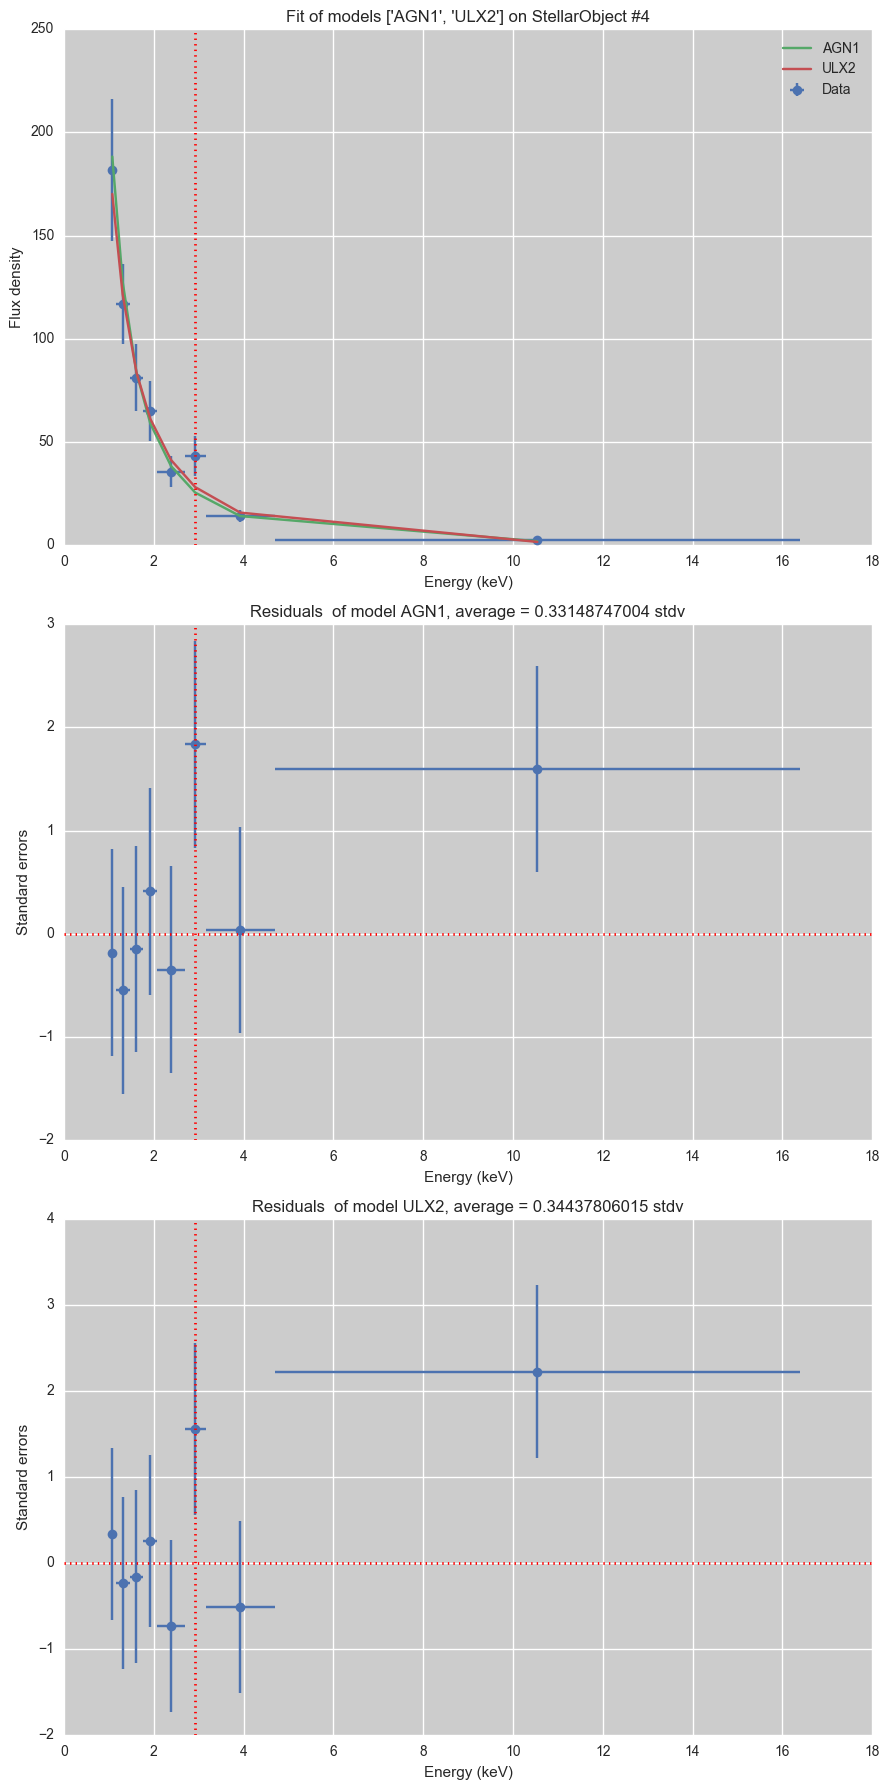

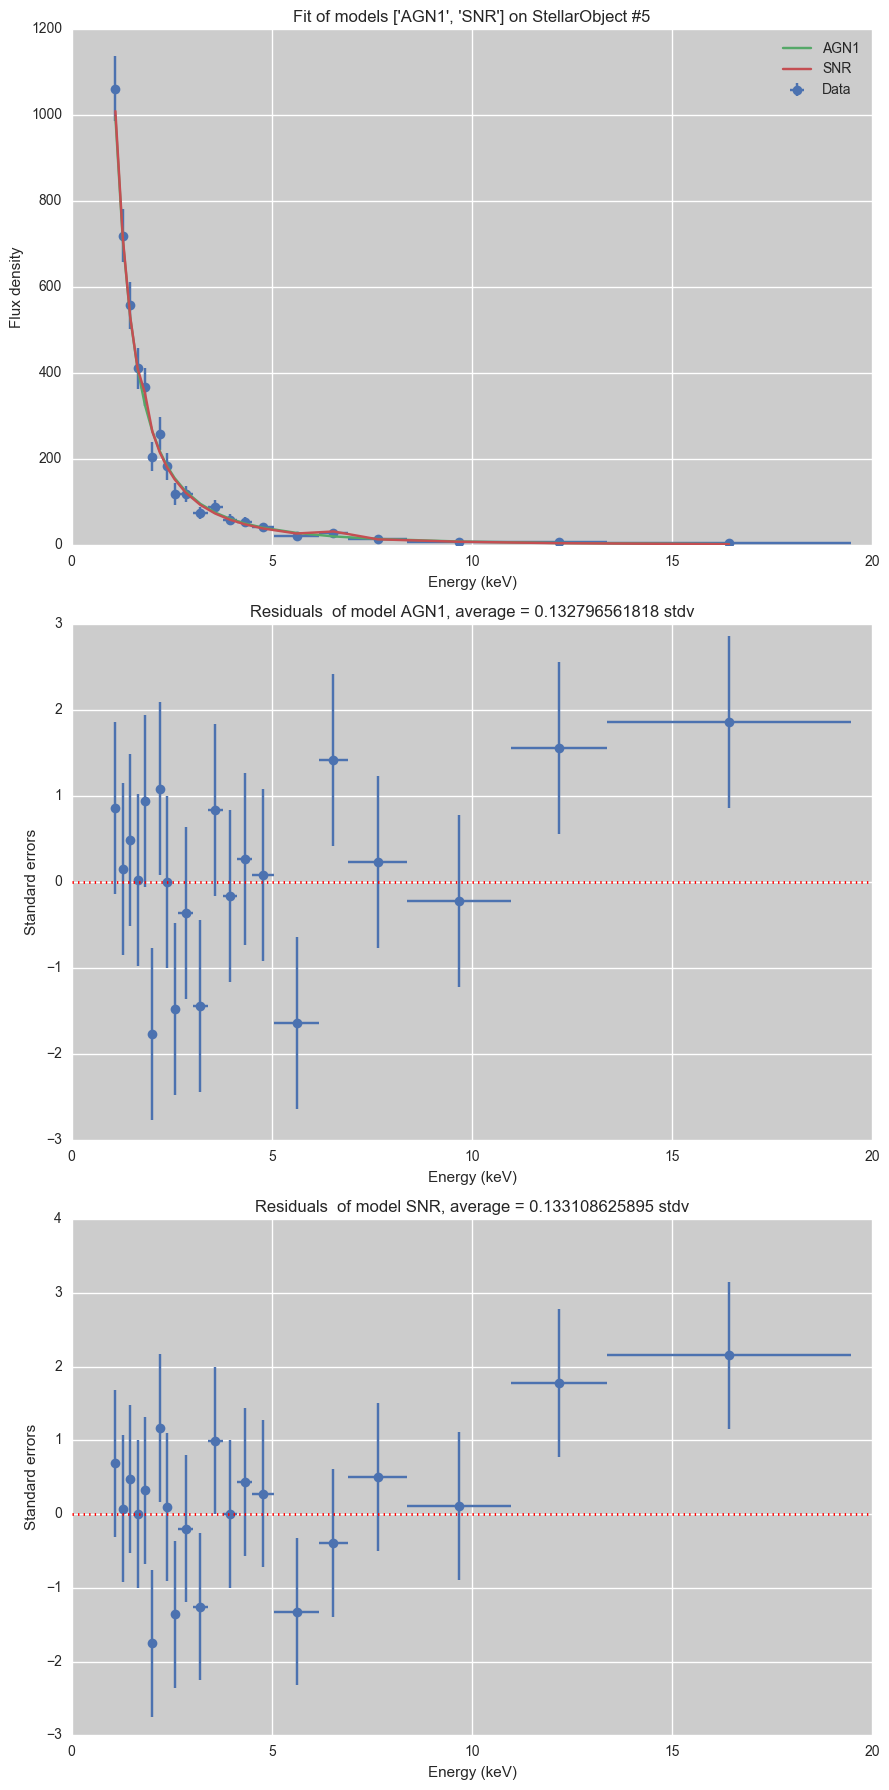

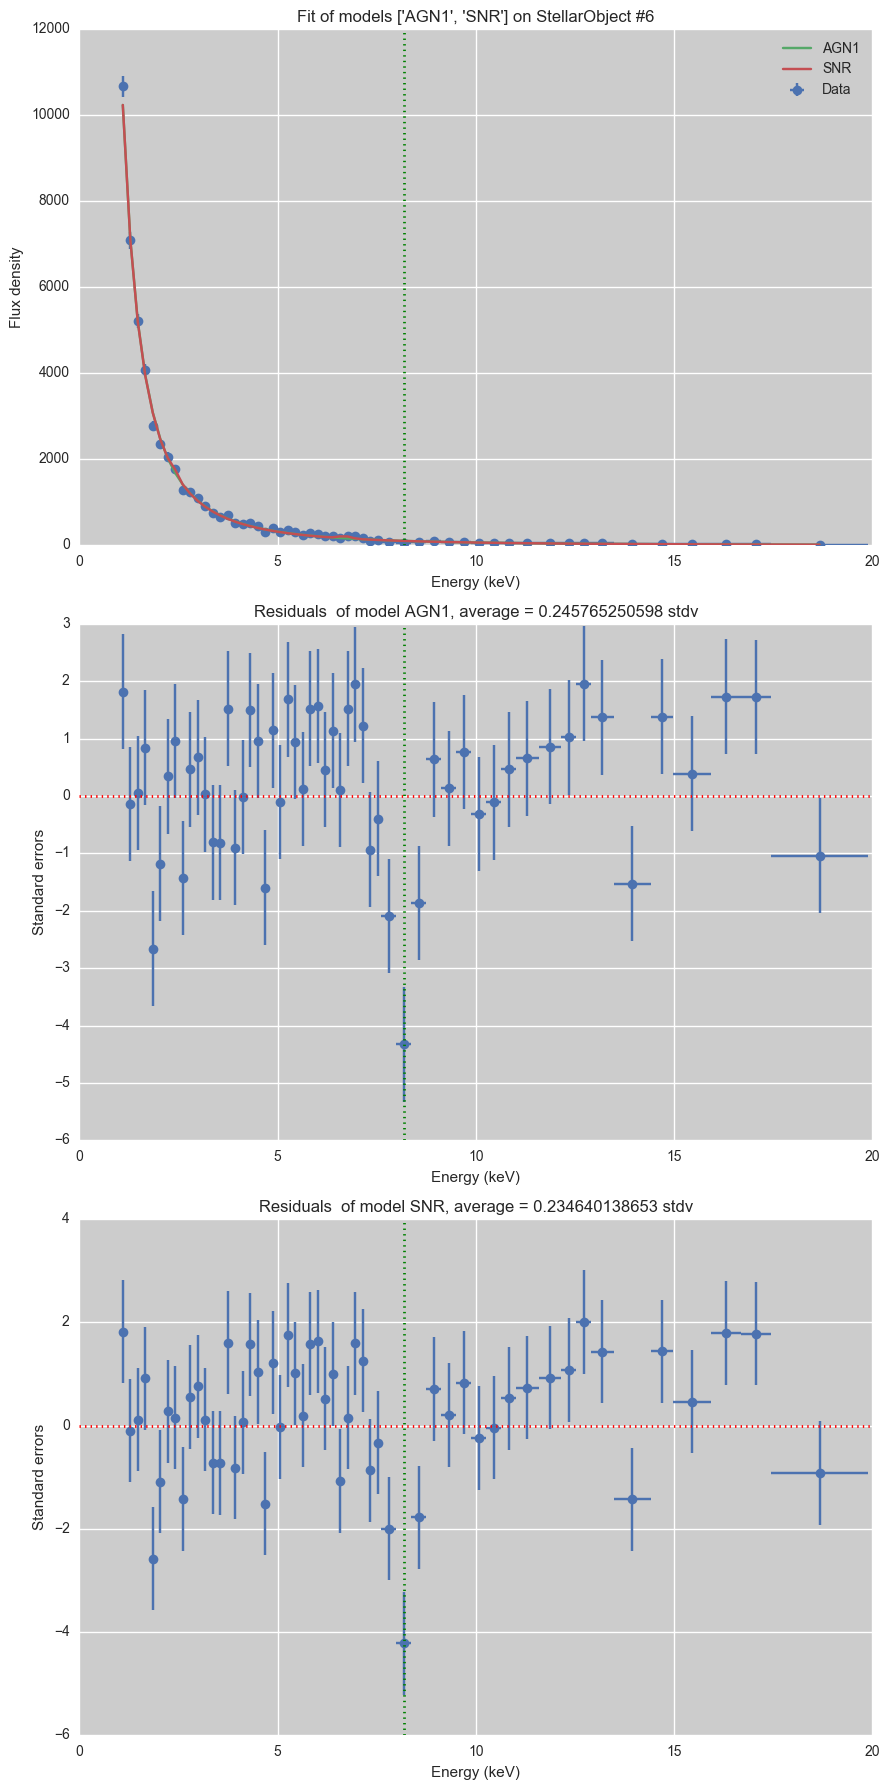

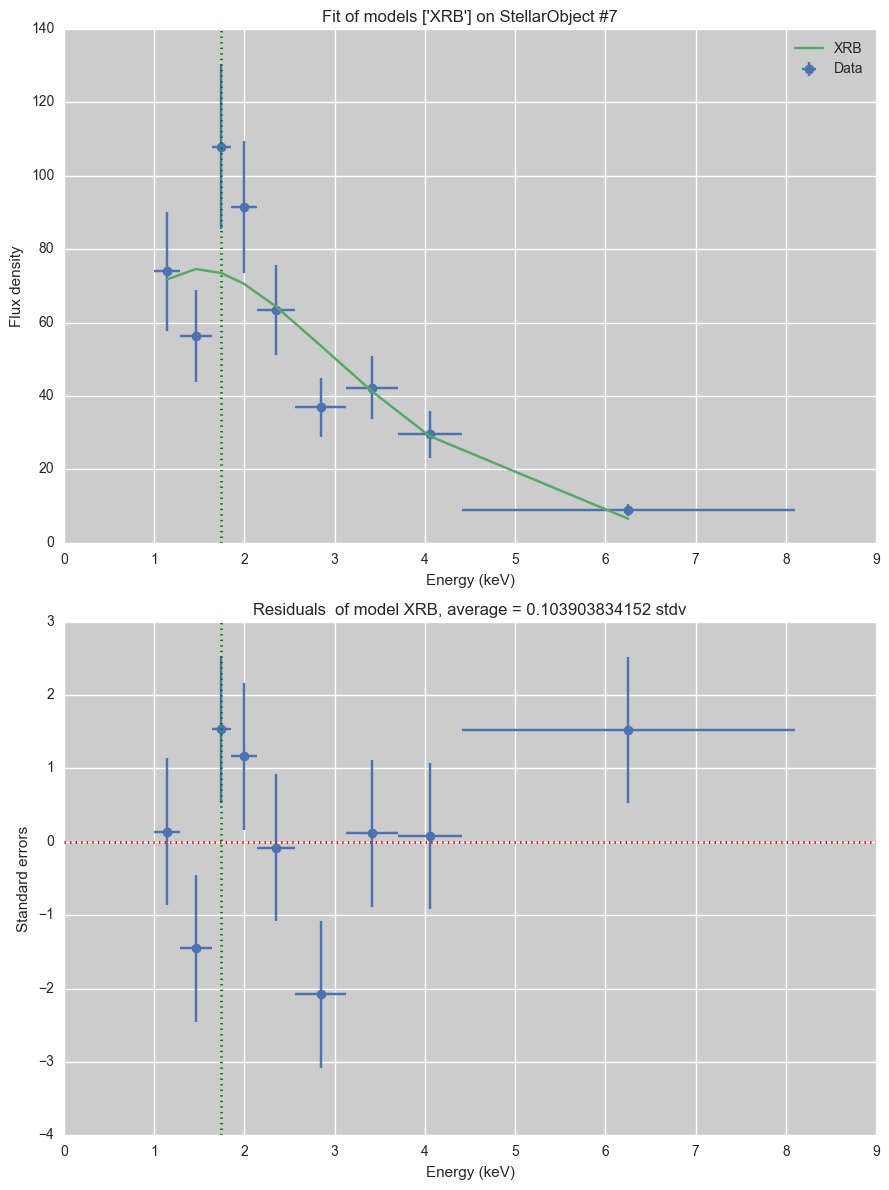

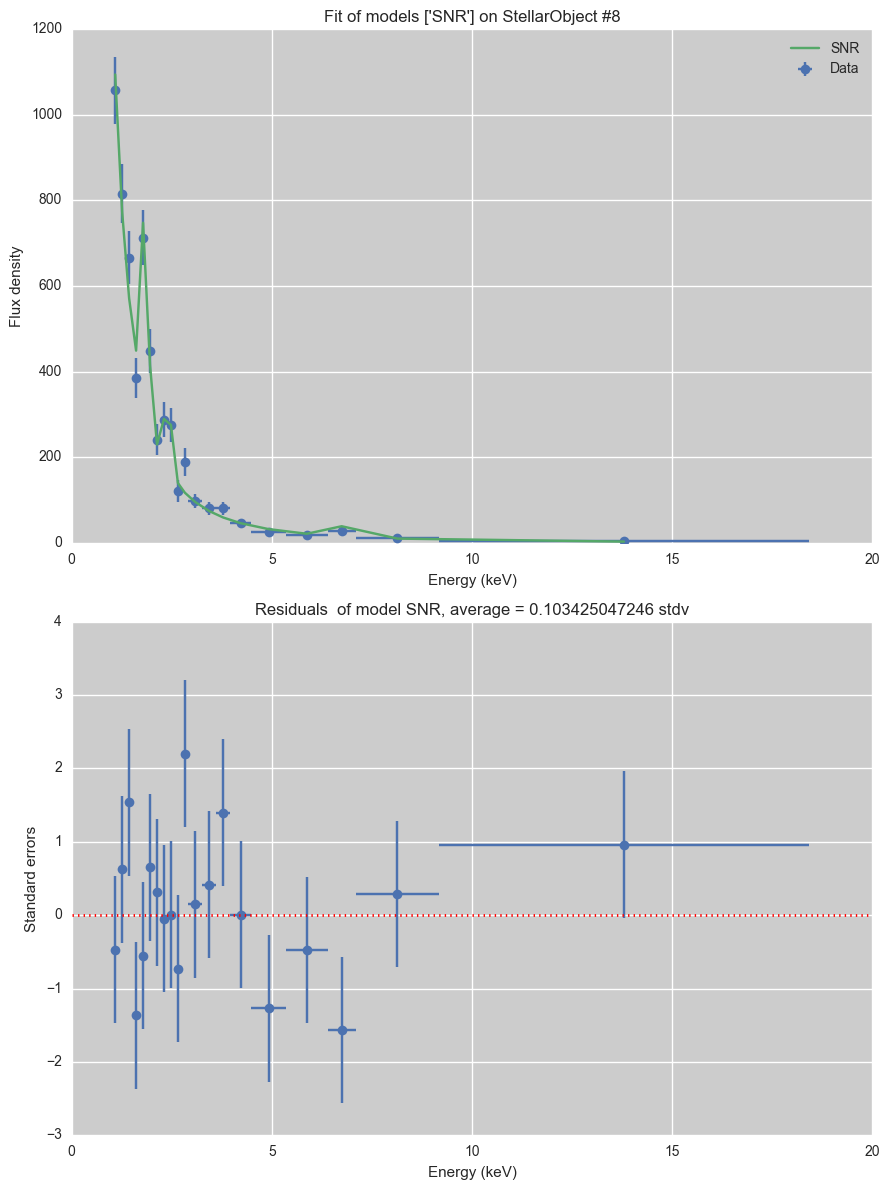

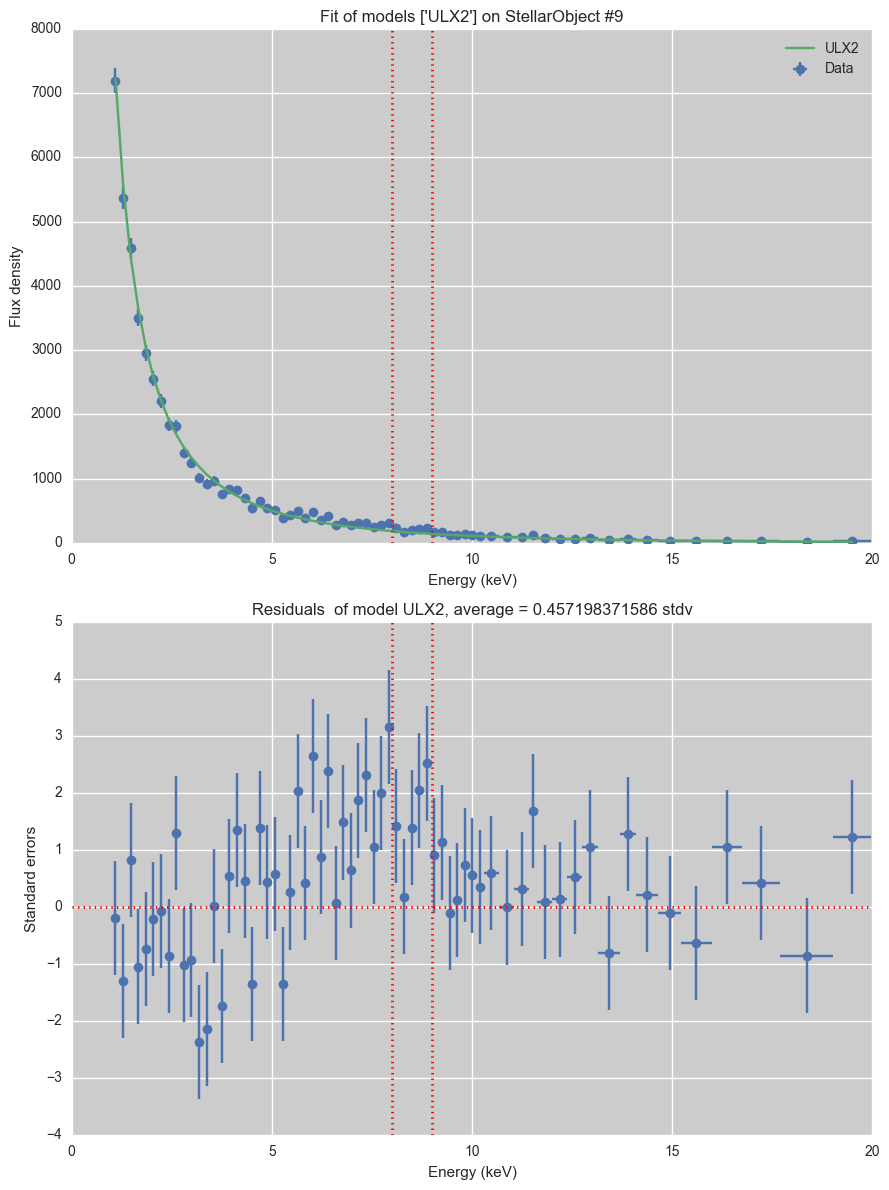

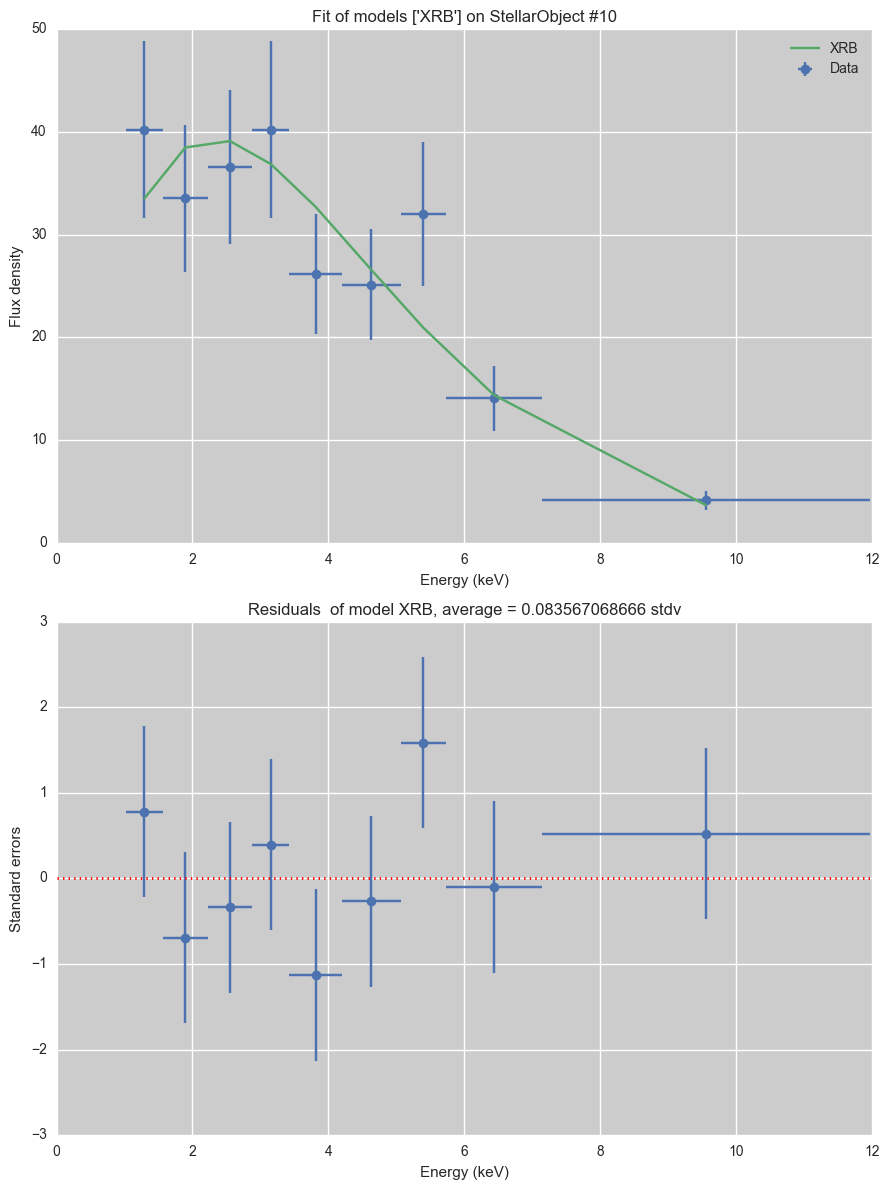

In [87]:
modelNameDict = {"ULX1": "Ultra-luminous X-ray source with break", 
                "ULX2": "Ultra-luminous X-ray source with exponentially cut-off power-law", 
                "SNR": "Young supernova remnant", 
                "XRB": "Ultrasoft X-ray binaries", 
                "AGN1":"Active Galactic Nuclei (Blazer)", 
                "AGN2":"Active Galactic Nuclei (Seyfert)",
                "power":"Power law witout shit"}


###
### These emission lines have been found bye eye, 
###
stellarObjects[0].possibleEmissionLines = [1.4725]
stellarObjects[0].possibleAbsorbtionLines = []
stellarObjects[1].possibleEmissionLines = [8.312]
stellarObjects[1].possibleAbsorbtionLines = []
stellarObjects[2].possibleEmissionLines = [5.6865]
stellarObjects[2].possibleAbsorbtionLines = []
stellarObjects[3].possibleEmissionLines = [2.92375]
stellarObjects[3].possibleAbsorbtionLines = []
stellarObjects[4].possibleEmissionLines = []
stellarObjects[4].possibleAbsorbtionLines = []
stellarObjects[5].possibleEmissionLines = []
stellarObjects[5].possibleAbsorbtionLines = [8.182]
stellarObjects[6].possibleEmissionLines = []
stellarObjects[6].possibleAbsorbtionLines = [1.7455]
stellarObjects[7].possibleEmissionLines = []
stellarObjects[7].possibleAbsorbtionLines = []
stellarObjects[8].possibleEmissionLines = [8, 9]
stellarObjects[8].possibleAbsorbtionLines = []
stellarObjects[9].possibleEmissionLines = []
stellarObjects[9].possibleAbsorbtionLines = []    


stillInterrestingFrac = 10

for stellarObject in stellarObjects:     
    ###
    ### Make a summary of the results and decide which warrent futher investigation, also save them for later
    ###
    
    print "\n\n\n==========================={}   ({} data points)===========================".format(
    stellarObject.name, len(stellarObject.data))
    stellarObject.interrestingModels = {}
    ###
    ### Get the values of the best fitting model
    ##
    bestXhi = stellarObject.results[stellarObject.bestFittingModel]["fun"]
    bestDof = len(stellarObject.density) - len(stellarObject.results[stellarObject.bestFittingModel]["x"])
    bestGof = scipy.stats.chi2.sf(bestXhi, df=bestDof)
    ###
    ### Check for each model if it is worth investigating further
    ###
    for model in stellarObject.results.keys():
        xhi = stellarObject.results[model]["fun"]
        dof = len(stellarObject.density) - len(stellarObject.results[model]["x"])
        gof = scipy.stats.chi2.sf(xhi, df=dof)
        
        worthInvestigating = ""
        if gof > bestGof/stillInterrestingFrac:
            stellarObject.interrestingModels[model] = gof
            worthInvestigating = "<=====" 
        print "{}: \t gof: {:.4e} \t dof:{}\t {}".format(model, gof, dof, worthInvestigating)
    
    ###
    ### Make a plot of the interresting models and residuals to indentify possible abosrbion/emission lines
    ###
    plotFitResiduals(stellarObject, stellarObject.interrestingModels.keys(), stellarObject.possibleAbsorbtionLines, 
                     stellarObject.possibleEmissionLines)
    


## Fitting the emission lines
Now we try to improve on the fits by adding emission/absorbtion lines

In [1]:
def checkLinesImprovesModel(extraParm, extraBound, stellarObject, model):
    ###
    ### Fitting the models with the spectral lines
    ###
    for model in stellarObject.interrestingModels:
        print "Fitting lines at {} to model {} for {}".format(extraParm[1::2], model, stellarObject.name)
        
        ###
        ### Set the previous fit parameters and only free up the spectral line
        ###
        startingParm = np.concatenate((stellarObject.results[model]["x"], extraParm))
        specificBounds = np.concatenate(([(par, par) for par in stellarObject.results[model]["x"]], extraBound))
            
        
        if len(stellarObject.data) > 1000:
            result = op.minimize(ChiSq_Integ, startingParm, args=(stellarObject.edges, stellarObject.density, 
                                                                  stellarObject.densityError, source, len(extraParm)/2),
                                 bounds=specificBounds, options={"maxiter":100})            
        else:
            result = op.minimize(LogLikelihood_Pois_Integ, startingParm, args=(stellarObject.edges, stellarObject.counts,
                                                                               source, len(extraParm)/2), 
                                 bounds=specificBounds, options={"maxiter":100})            

        ###
        ### Check if the models is impoved by the lines
        ### This consists of removing one degree of freedom per line and correcting for the number of bins
        ###
        oldChi = stellarObject.results[model]["fun"]
        newChi = result["fun"]
        deltaChi = newChi - oldChi
        print oldChi, newChi

        pval = scipy.stats.chi2(1).sf(deltaChi)
        correctedPval = 1.0-np.power((1.0-pval),len(stellarObject.centres)) 
        if pval < 0.01:
            print "By adding an extra line the fit was improved! Number of trials corrected pval: {}".format(pval)
            stellarObject.results[model + "{}spectralLines".format(len(extraParm)/2)] = result


            ###
            ### Print some output to see what the program is doing
            ###
            ml_vals = result["x"]
            ml_func = result["fun"]
            
            pval = scipy.stats.chi2.sf(ml_func, df=len(stellarObject.density) - len(startingParm) + len(extraParm)/2)
            print "Minimum Chi-squared: {} for {} d.o.f.".format(ml_func,len(stellarObject.density)-len(startingParm) + len(extraParm)/2)
            print "The goodness of fit is: {}".format(pval)
        else:
            print "By adding an extra line the fit was NOT improved! Number of trials corrected pval: {}".format(pval)
        
        plotFitResiduals(stellarObject, [model + "{}spectralLines".format(len(extraParm)/2)])   
            
            
    


In [3]:
print "Starting with adding the lines to the fits"

   
###
### Check if models are improved by the possible emissions lines where they were observed
###
for stellarObject in stellarObjects[2:3]:
    print "\n\n\n==========================={}   ({} data points)===========================".format(
    stellarObject.name, len(stellarObject.data))
    if (len(stellarObject.possibleAbsorbtionLines) + len(stellarObject.possibleEmissionLines)) == 0:
        continue
    
    
    ###
    ### Calculate the xtra parameters and bounds needed
    ###
    extraParm1, extraBound1, extraParm2, extraBound2 = [], [], [], []
    
    for emissionLine in stellarObject.possibleEmissionLines:
        extraParm1 += [50, emissionLine] # nomalisation, location
        extraBound1 += [(None, None), (None, None)] 
        checkLinesImprovesModel(extraParm1, extraBound1, stellarObject, model)

    for absorbtionLine in stellarObject.possibleAbsorbtionLines:
        extraParm2 += [absorbtionLine, -1000]
        extraBound2 += [(None, None), (None, None)]
        checkLinesImprovesModel(extraParm2, extraBound2, stellarObject, model)
    
    if len(extraParm1) > 0 and len(extraParm2) > 0:
        checkLinesImprovesModel(extraParm1 + extraParm2, extraBound1 + extraBound2, stellarObject, model)


Starting with adding the lines to the fits


NameError: name 'stellarObjects' is not defined

In [144]:
print add_emmision_line(stellarObjects[2].centres,   50.,5.6865 )
# print scipy.stats.norm.pdf(4, 5, .3)


# def add_emmision_line2(E, lineNormalisation, lineEnergie):
#     sigma = 0.06*np.sqrt(lineEnergie)
#     print sigma
#     return scipy.stats.norm.pdf(E, lineEnergie, sigma)*lineNormalisation
# print add_emmision_line2(2,   50.,5.6865 )

print scipy.stats.norm.pdf(5, 5, .14)
print stellarObjects[2].centres

[  1.33630771e-220   3.40525015e-203   2.03893059e-178   1.12857496e-140
   2.71076166e-095   4.18179103e-034   1.39413971e+002   0.00000000e+000]
2.84958771715
[  1.1115   1.2945   1.569    2.0265   2.667    3.8565   5.6865  13.0065]


For StellarObject #1 the best fitting model is: Ultra-luminous X-ray source with exponentially cut-off power-law. 
It has a chisqrd of 52.5084190832 with 47 d.o.f. 
This model gives a goodness of fit of 0.269098032852.    
N0: 12997.4709469 +/- 4.97379915032e-06
Ecut: 8.5883617175 +/- 0.00162287960848
Gamma: 1.85863024939 +/- -0.0313299608479

For StellarObject #2 the best fitting model is: Ultra-luminous X-ray source with exponentially cut-off power-law. 
It has a chisqrd of 24.8537712323 with 23 d.o.f. 
This model gives a goodness of fit of 0.357868801538.    
N0: 937.178500988 +/- 2.84217094304e-06
Ecut: 10.0 +/- -5.09218871514
Gamma: 1.5 +/- 137.748704532

For StellarObject #3 the best fitting model is: Active Galactic Nuclei (Seyfert). 
It has a chisqrd of 21.2684515658 with 5 d.o.f. 
This model gives a goodness of fit of 0.000720702105333.    
N0: 190.732108741 +/- 0.0
Gamma: 1.94966541182 +/- 6.39488462184e-06
FeStrength (at 6.4keV): 1.94966541182 +/- 6.39488462184e-06

For Stel

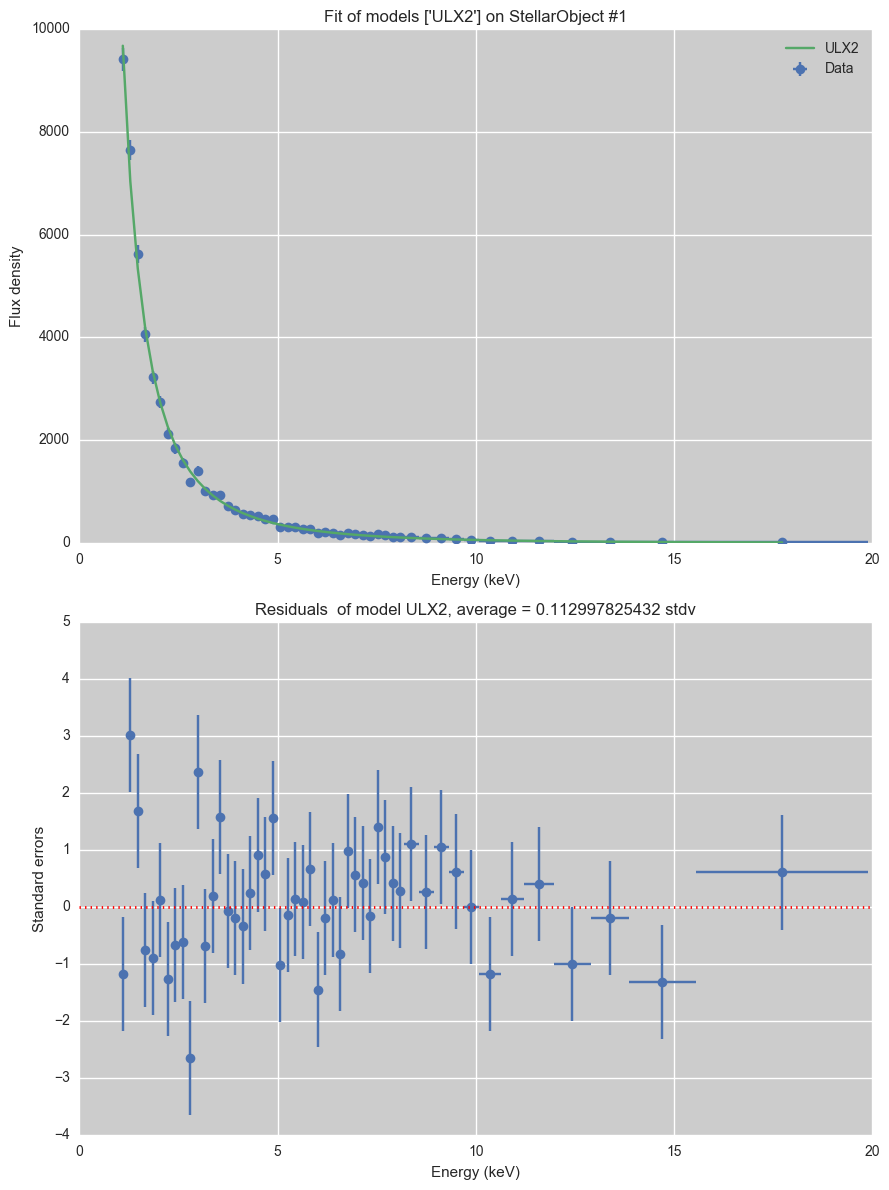

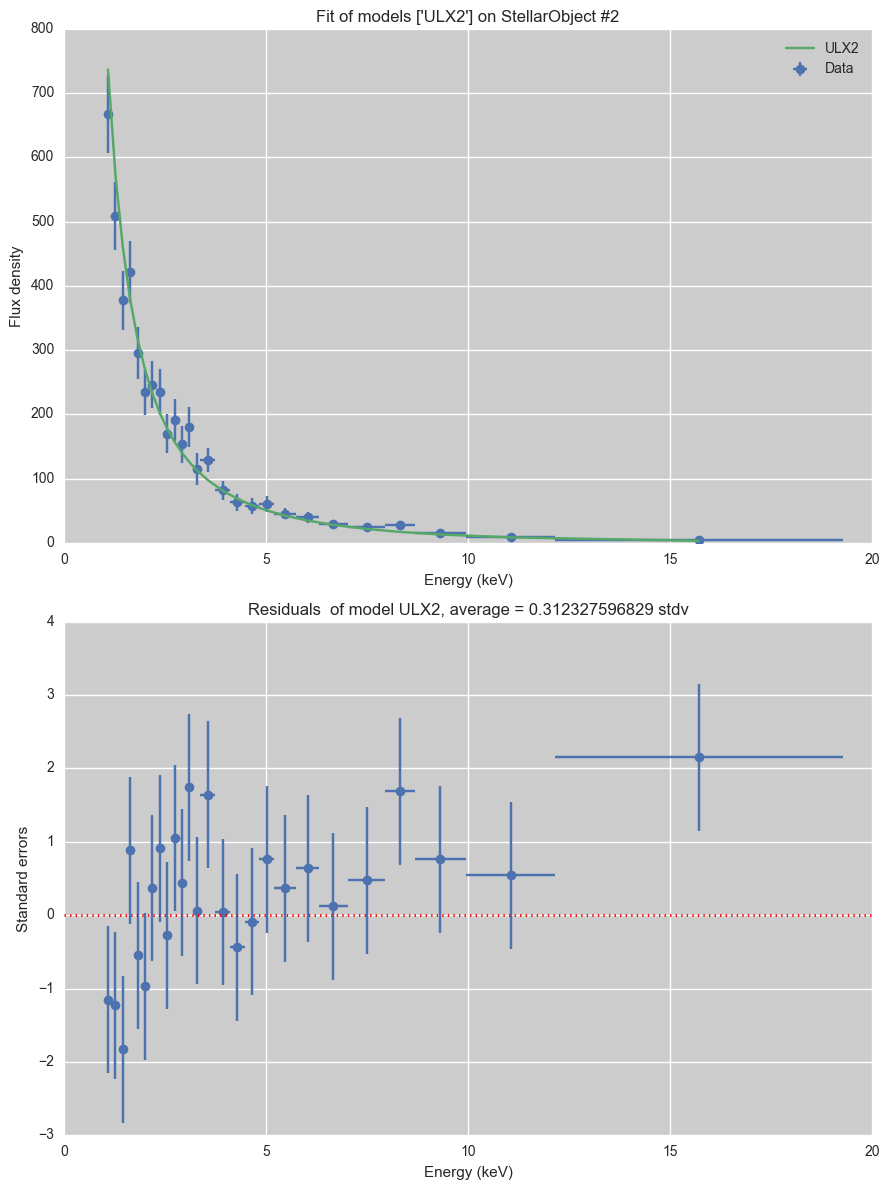

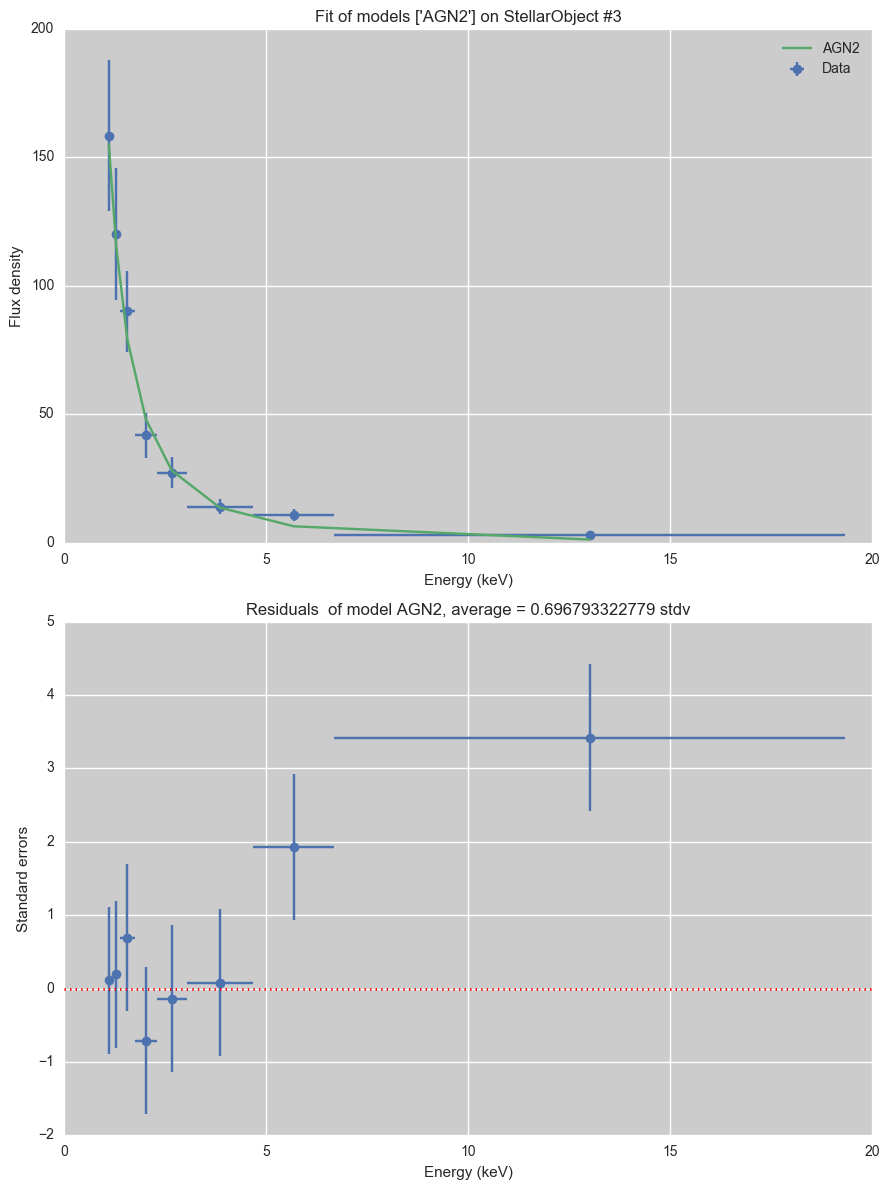

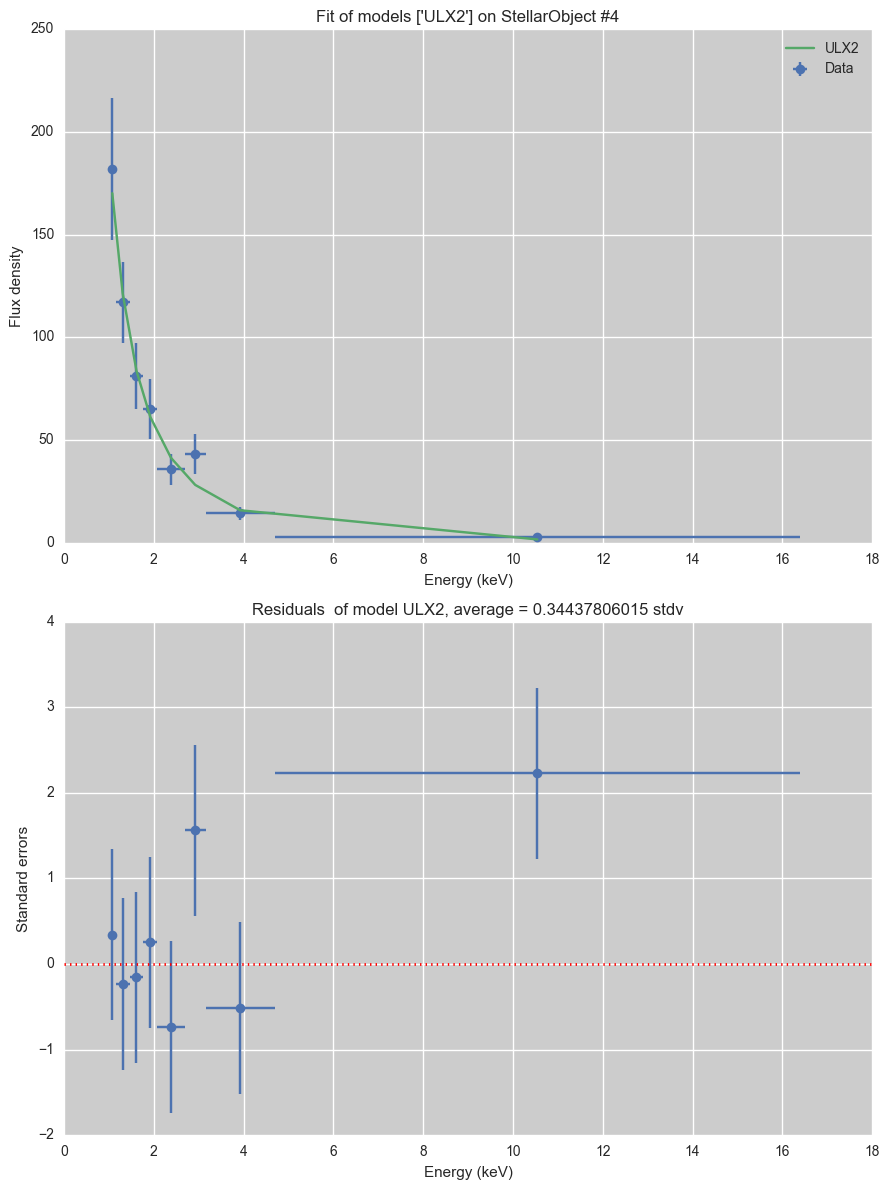

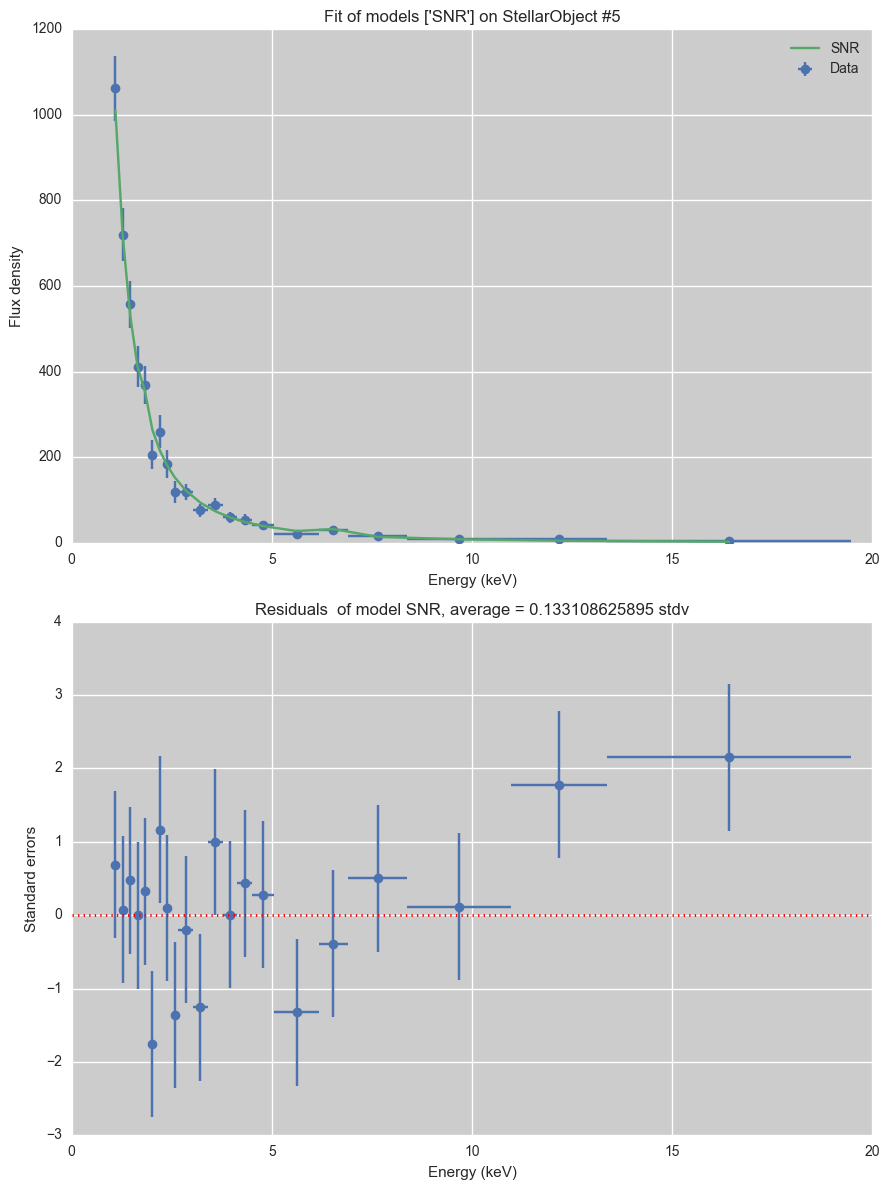

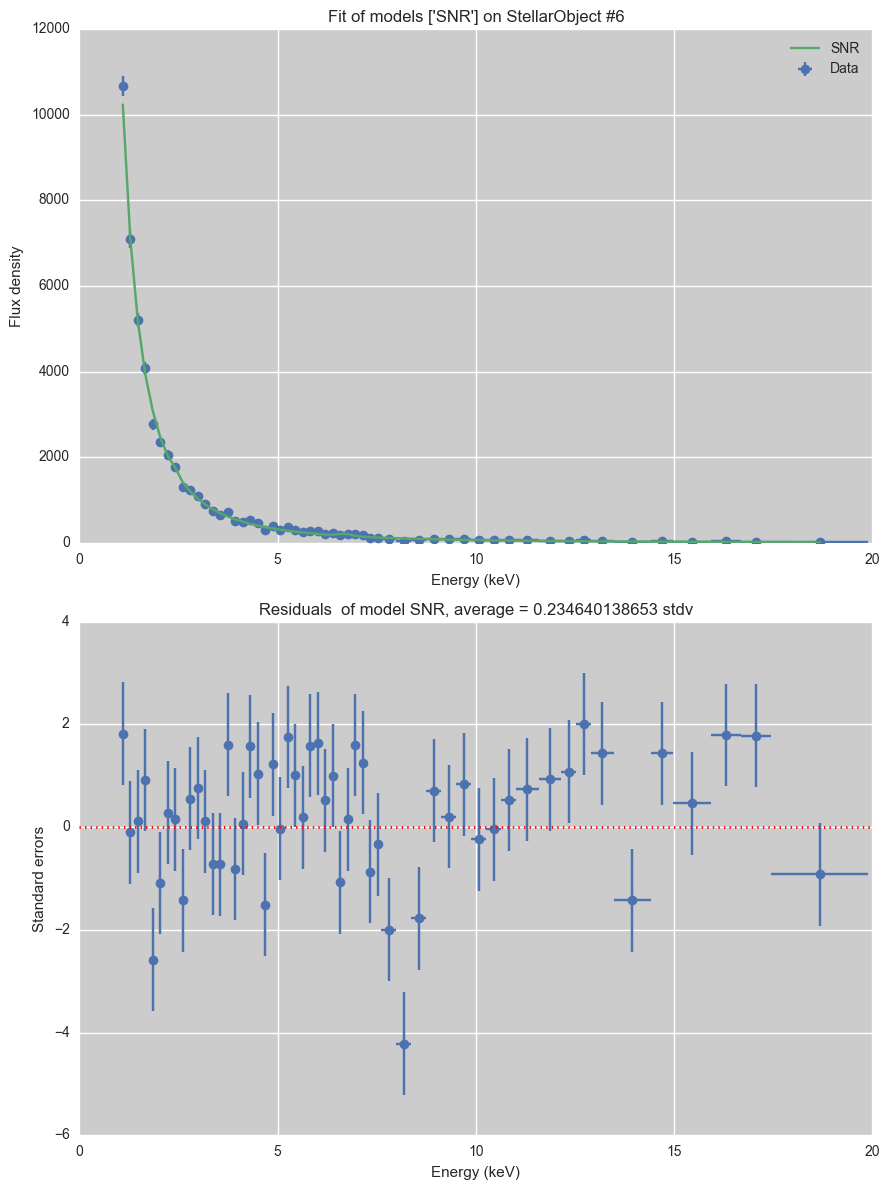

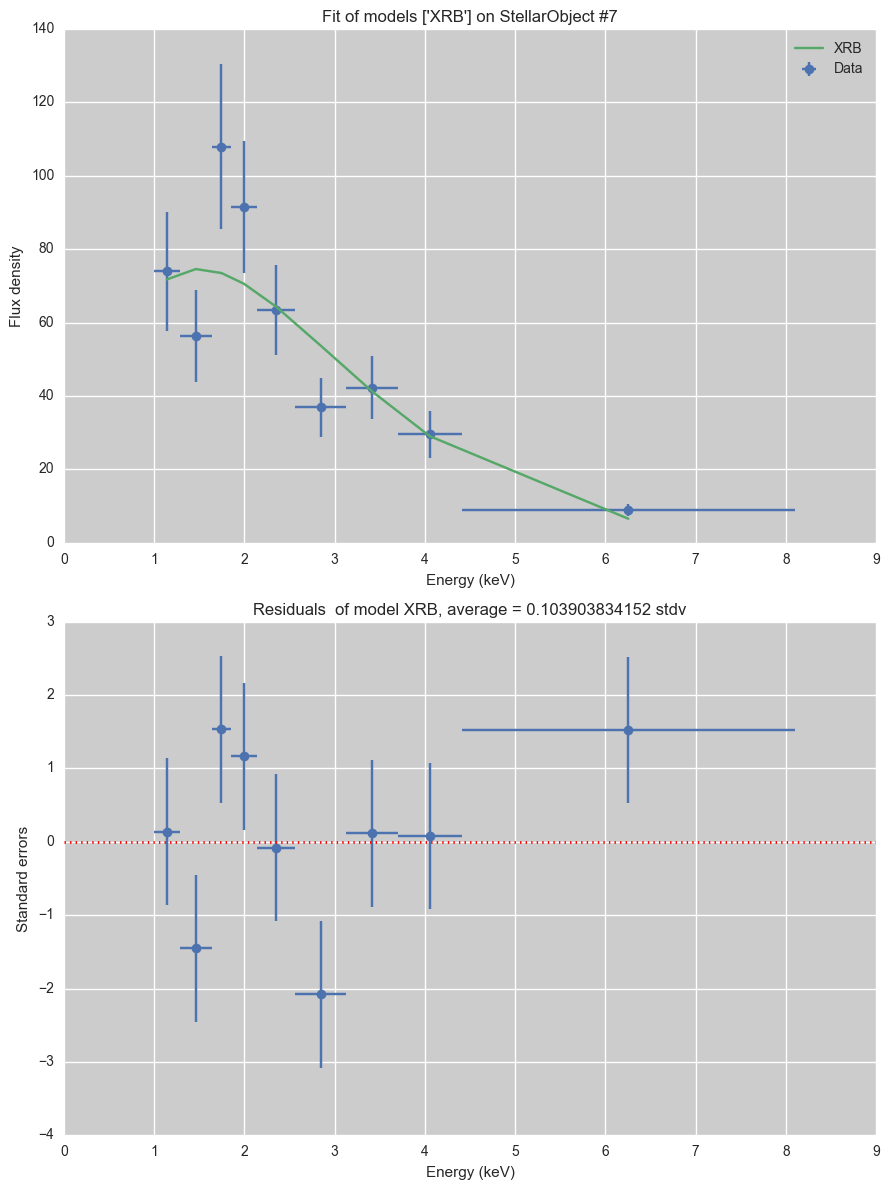

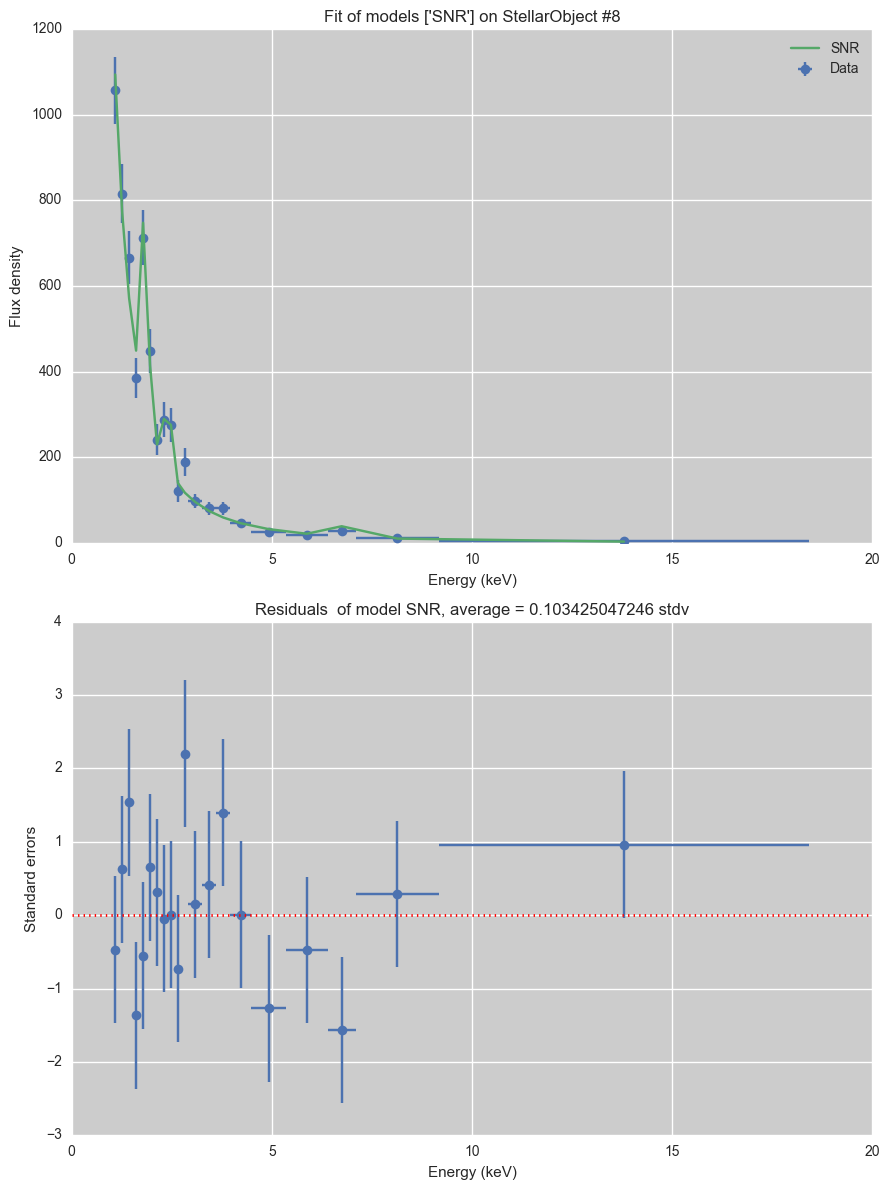

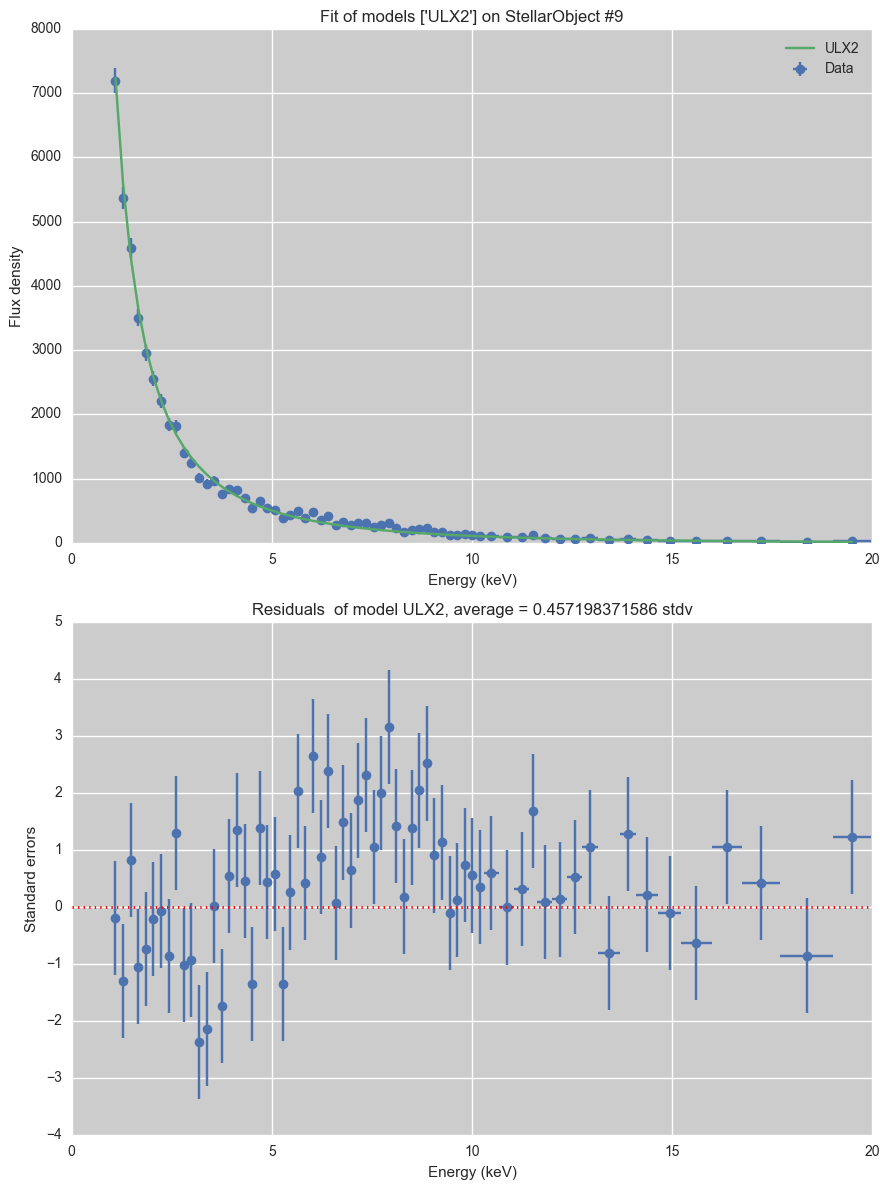

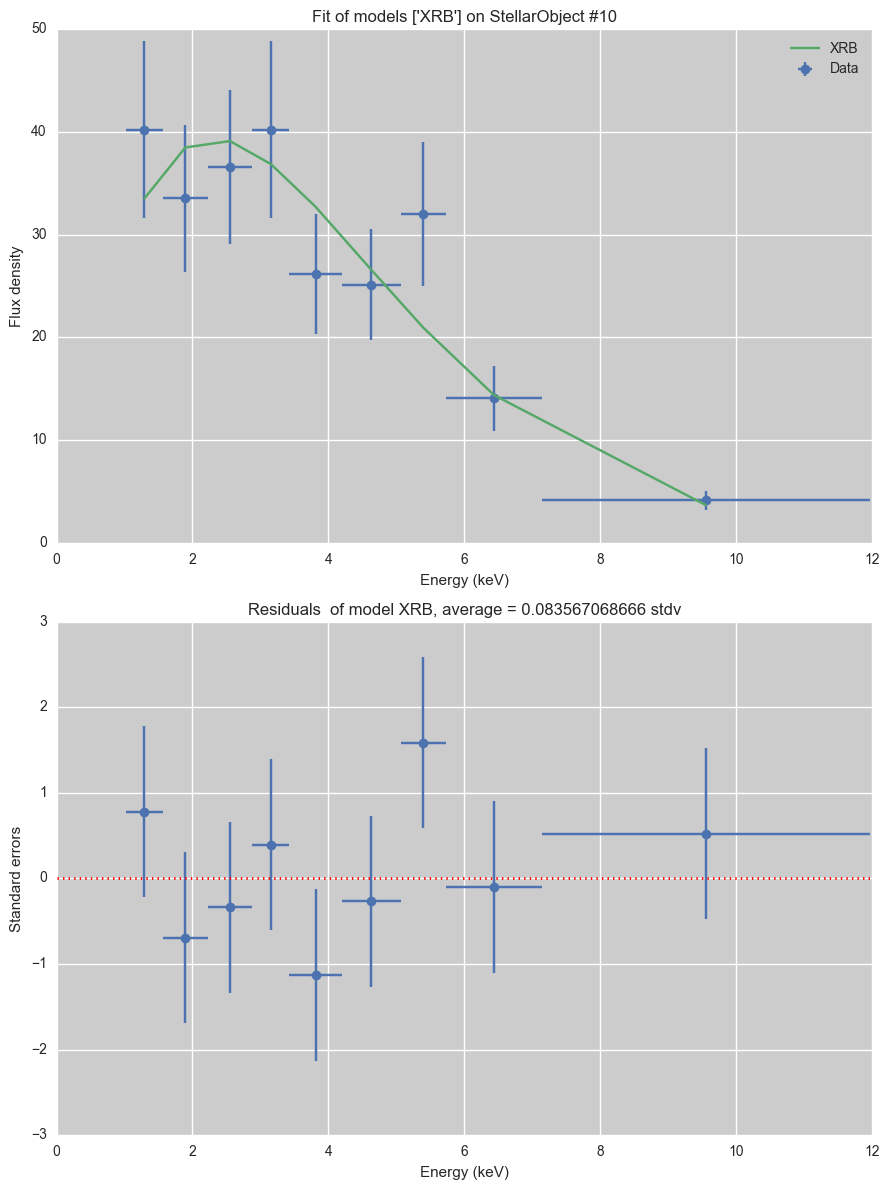

In [74]:
for stellarObject in stellarObjects:
    bestFit = np.inf
    
    ###
    ### Find wich of the models fits te data the best.
    ###
    for model in stellarObject.results.keys():
        result = stellarObject.results[model]

        if result["fun"] < bestFit:
            bestFit = result["fun"]
            stellarObject.bestFittingModel = model

            
    bestResult = stellarObject.results[stellarObject.bestFittingModel]
    chiSqrd = bestResult["fun"]
    parm = bestResult["x"]
    errorParm = bestResult["jac"]
    dof = len(stellarObject.density) - len(parm)
    pval = scipy.stats.chi2.sf(chiSqrd, df=len(stellarObject.density) - len(parm))

    print "For {} the best fitting model is: {}. \nIt has a chisqrd of {} with {} d.o.f. \nThis model gives a goodness of fit of {}.\
    ".format(stellarObject.name, modelNameDict[stellarObject.bestFittingModel],chiSqrd, dof, pval)
    
    printParmError(parm, errorParm, stellarObject.bestFittingModel)
    plotFitResiduals(stellarObject, [stellarObject.bestFittingModel])            
            


For StellarObject #1 the best fitting model is: Ultra-luminous X-ray source with exponentially cut-off power-law. 
It has a chisqrd of 52.5084190832 with 47 d.o.f. 
This model gives a goodness of fit of 0.269098032852.    
N0: 12997.4709469 +/- 4.97379915032e-06
Ecut: 8.5883617175 +/- 0.00162287960848
Gamma: 1.85863024939 +/- -0.0313299608479

For StellarObject #2 the best fitting model is: Ultra-luminous X-ray source with exponentially cut-off power-law. 
It has a chisqrd of 24.8537712323 with 23 d.o.f. 
This model gives a goodness of fit of 0.357868801538.    
N0: 937.178500988 +/- 2.84217094304e-06
Ecut: 10.0 +/- -5.09218871514
Gamma: 1.5 +/- 137.748704532

For StellarObject #3 the best fitting model is: Active Galactic Nuclei (Seyfert). 
It has a chisqrd of 21.2684515658 with 5 d.o.f. 
This model gives a goodness of fit of 0.000720702105333.    
N0: 190.732108741 +/- 0.0
Gamma: 1.94966541182 +/- 6.39488462184e-06
FeStrength (at 6.4keV): 1.94966541182 +/- 6.39488462184e-06

For Stel

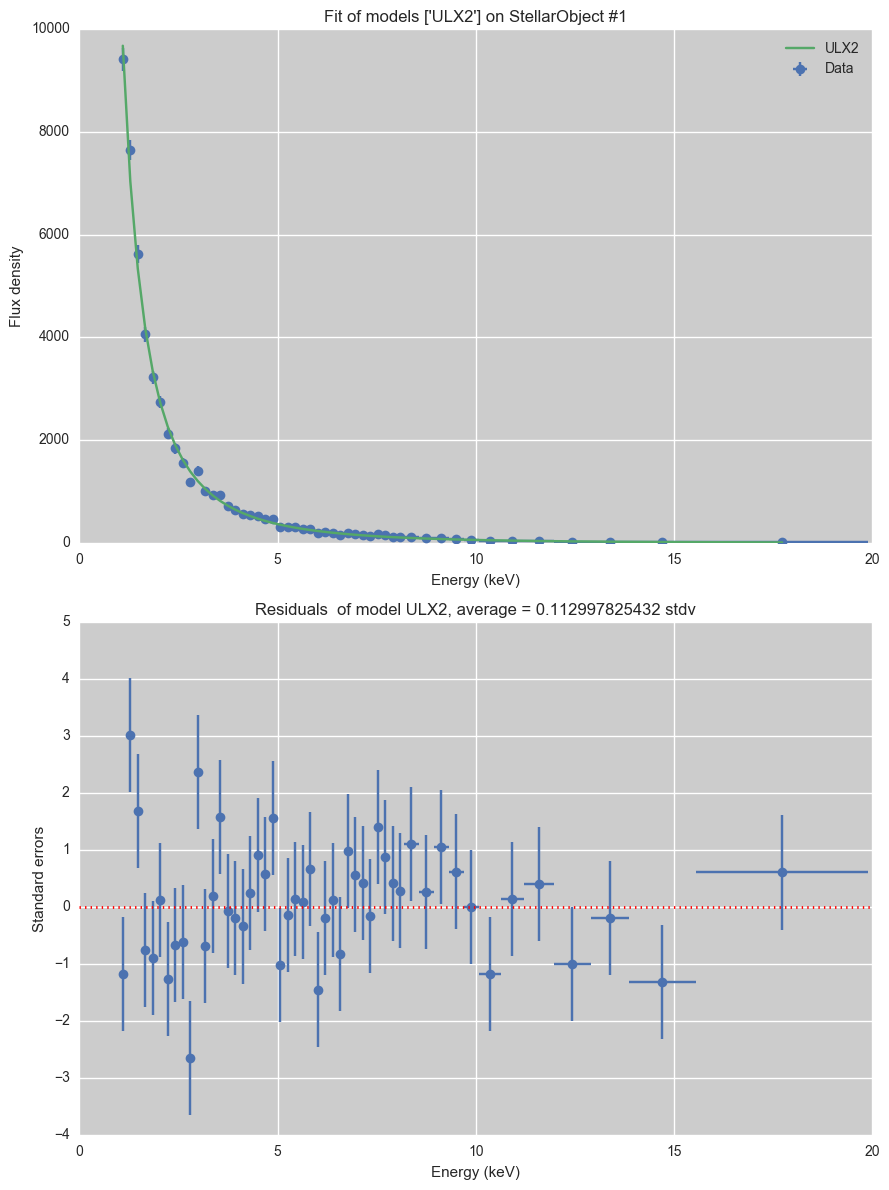

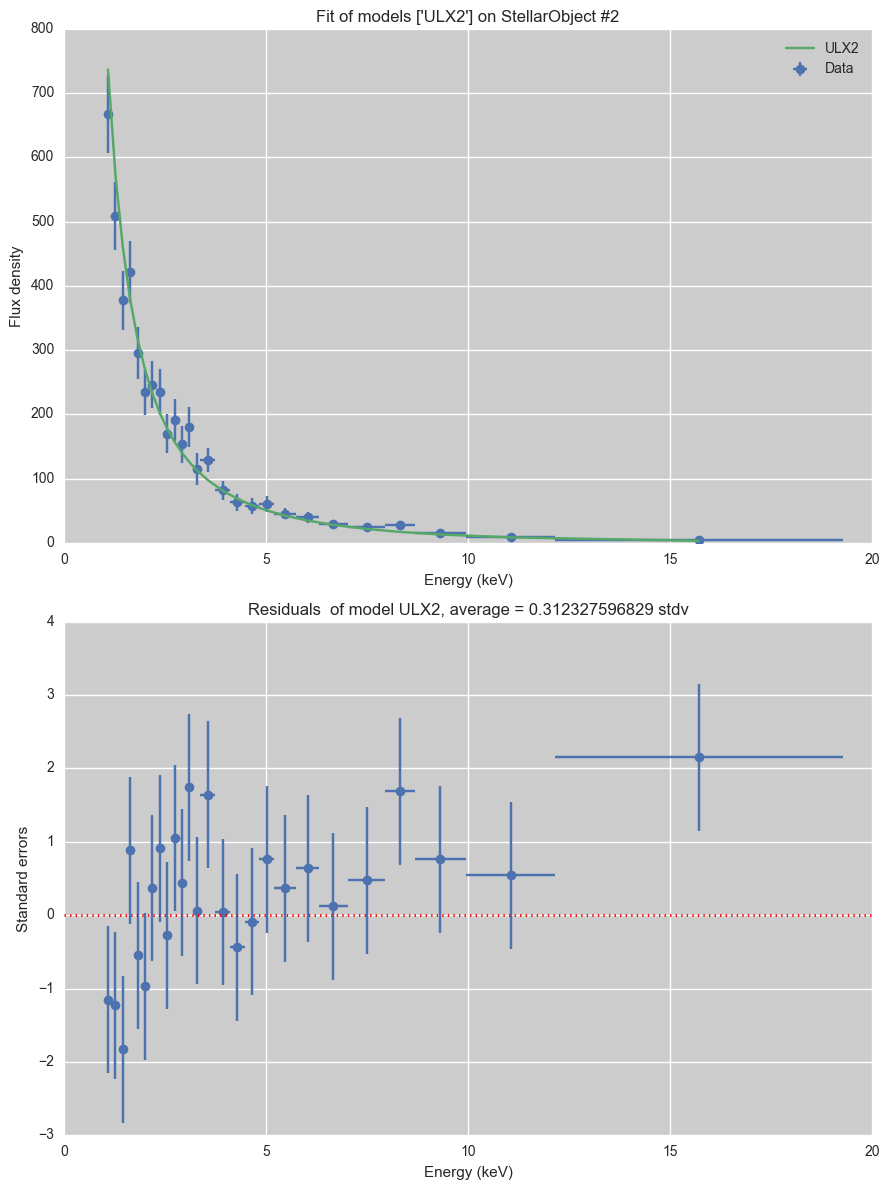

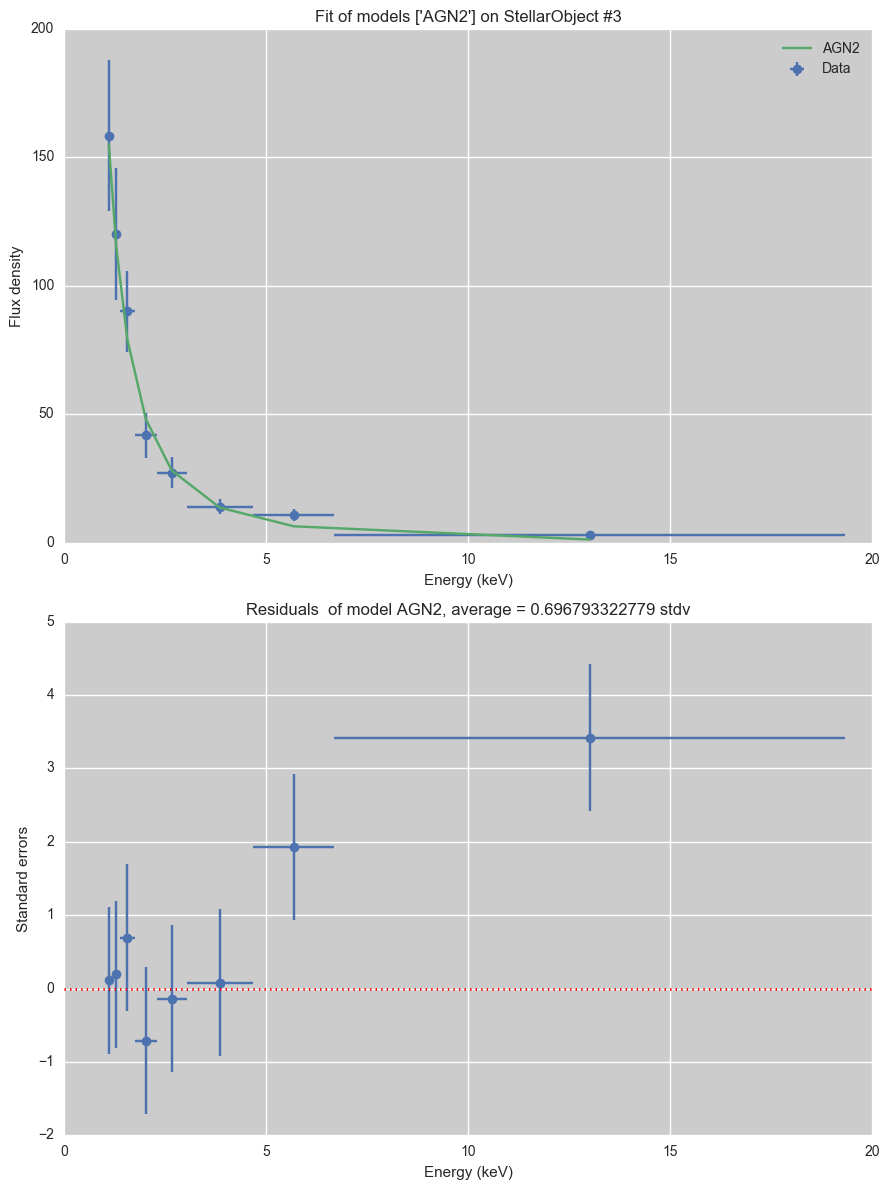

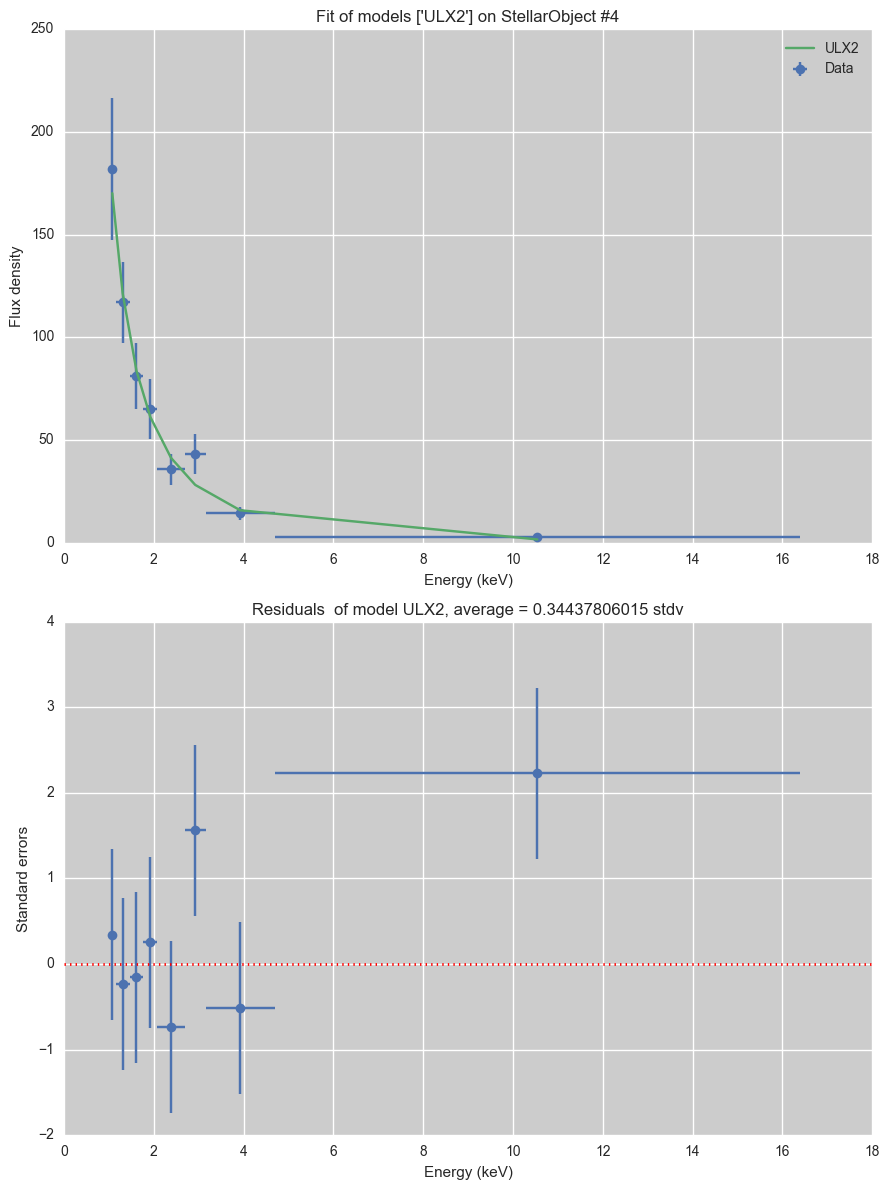

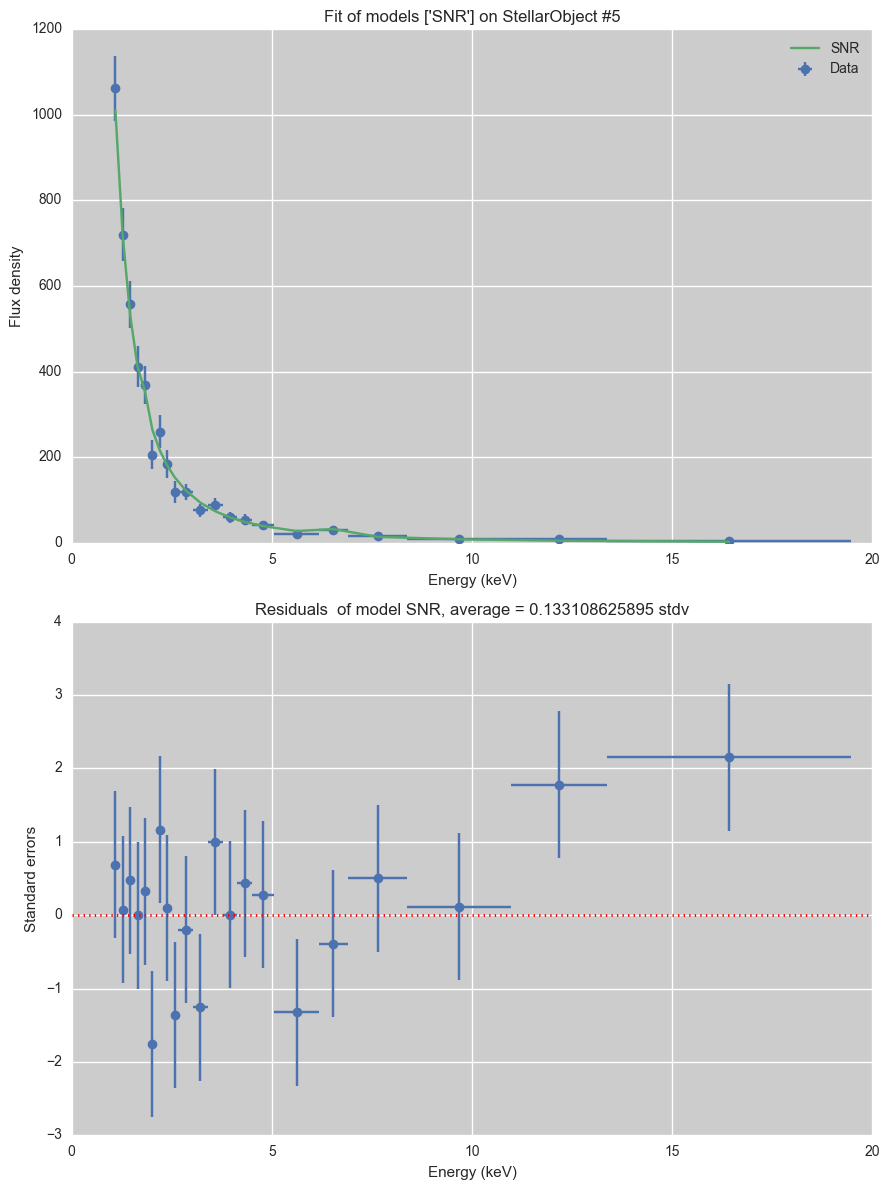

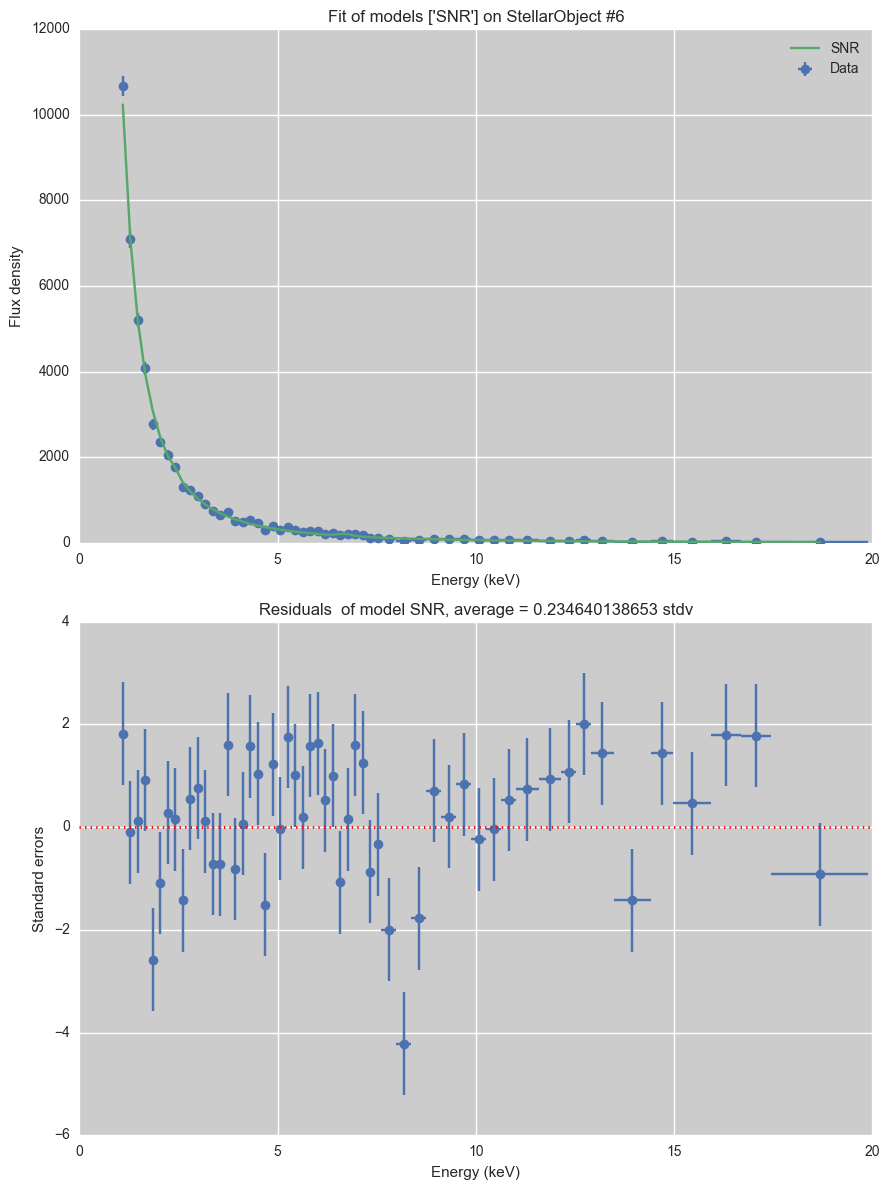

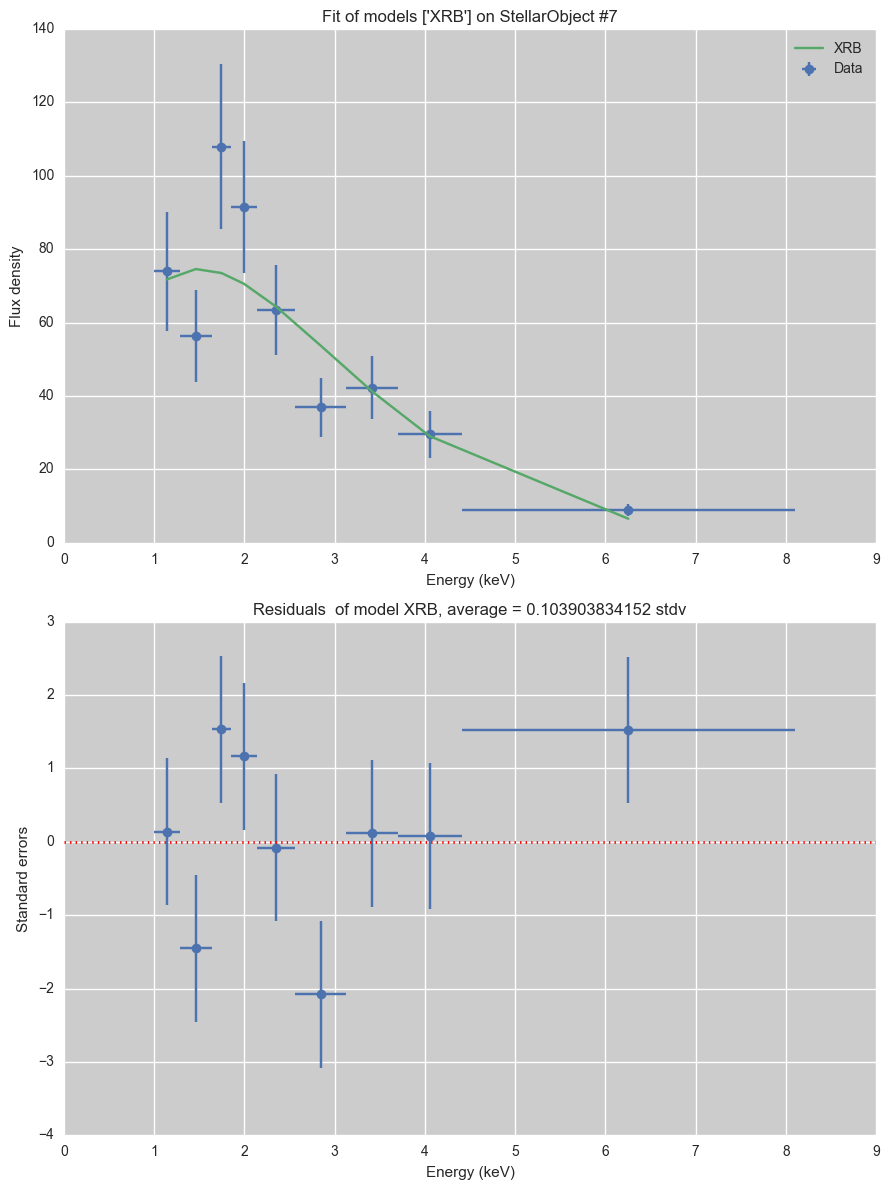

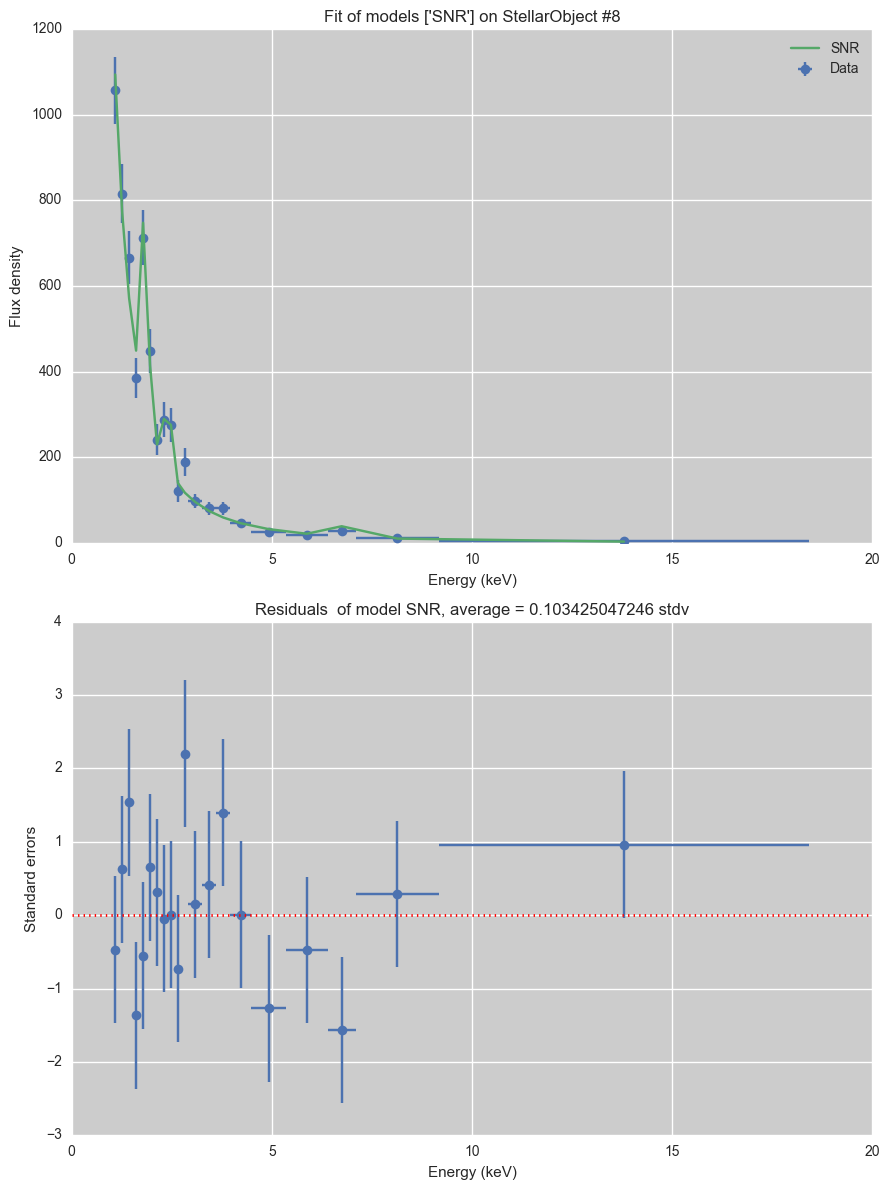

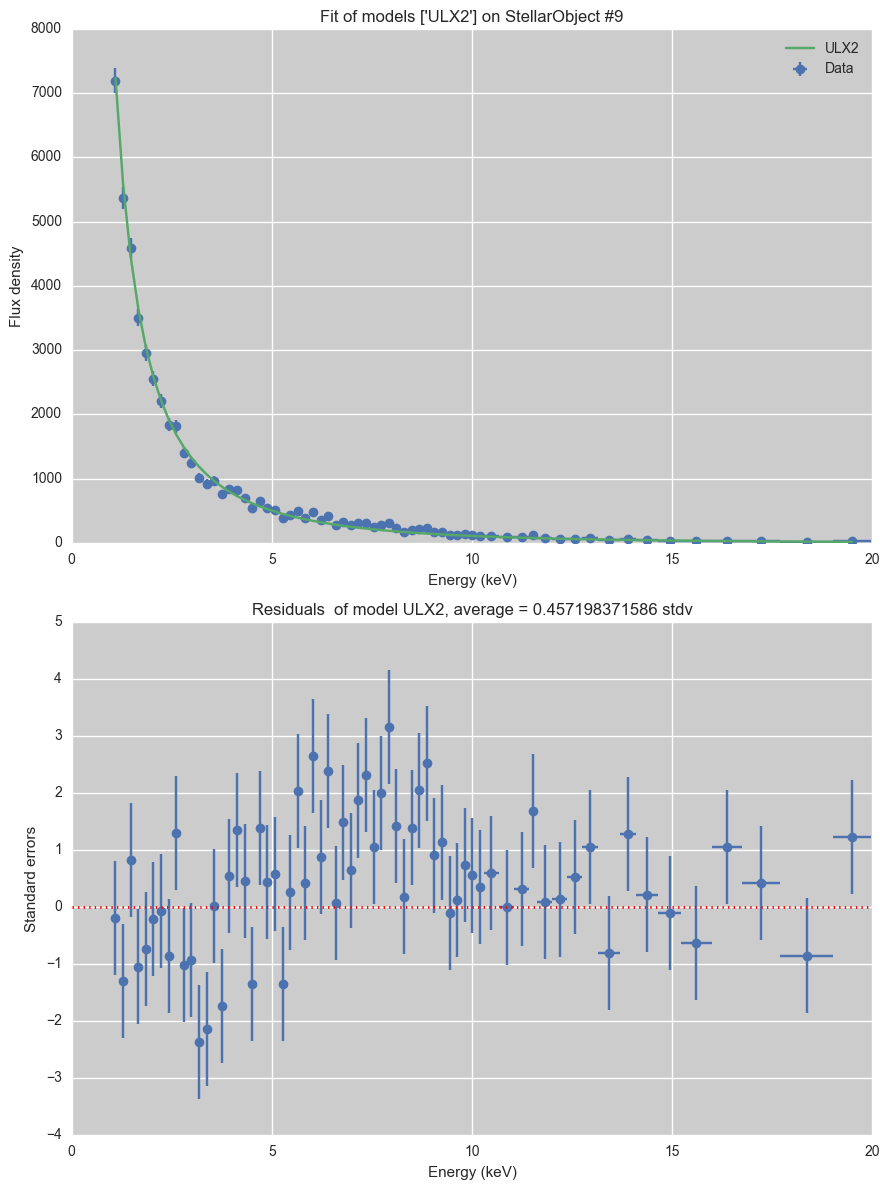

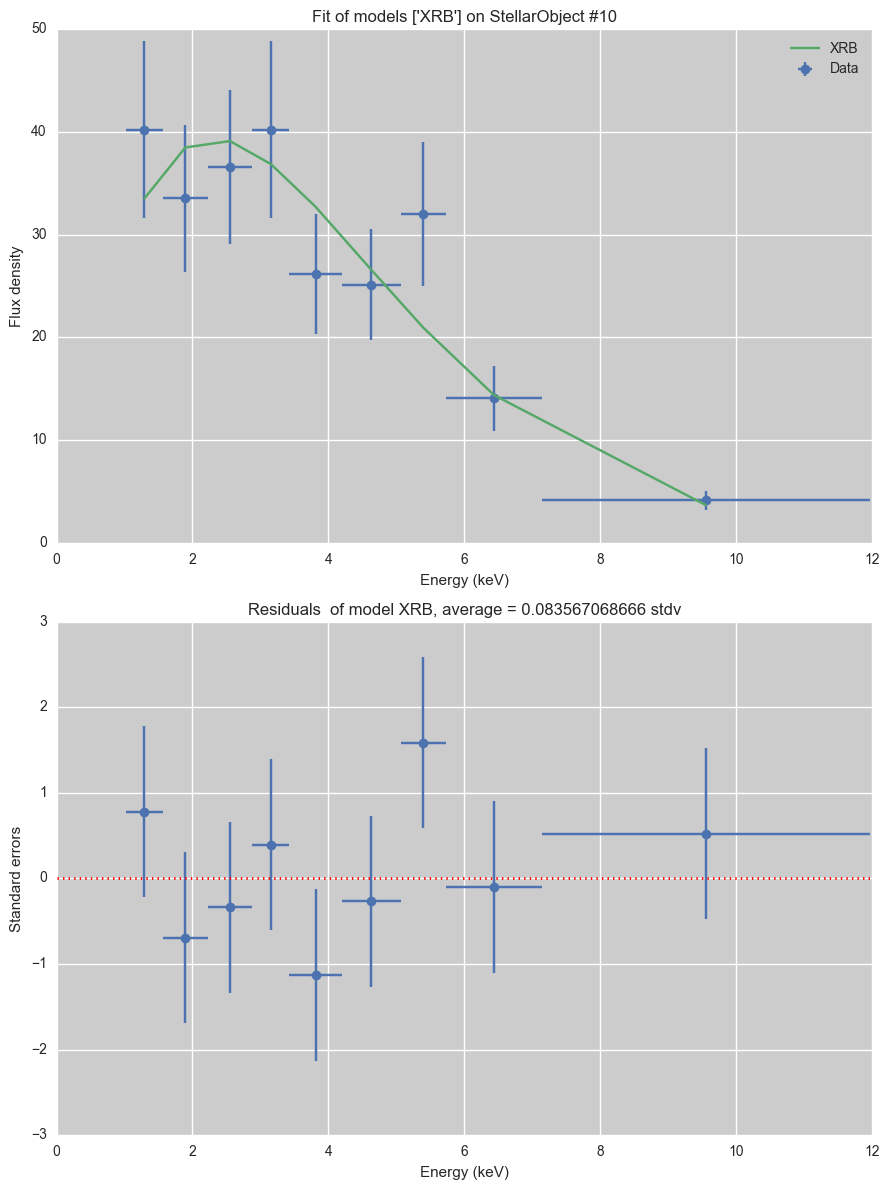

In [74]:
for stellarObject in stellarObjects:
    bestFit = np.inf
    
    ###
    ### Find wich of the models fits te data the best.
    ###
    for model in stellarObject.results.keys():
        result = stellarObject.results[model]

        if result["fun"] < bestFit:
            bestFit = result["fun"]
            stellarObject.bestFittingModel = model

            
    bestResult = stellarObject.results[stellarObject.bestFittingModel]
    chiSqrd = bestResult["fun"]
    parm = bestResult["x"]
    errorParm = bestResult["jac"]
    dof = len(stellarObject.density) - len(parm)
    pval = scipy.stats.chi2.sf(chiSqrd, df=len(stellarObject.density) - len(parm))

    print "For {} the best fitting model is: {}. \nIt has a chisqrd of {} with {} d.o.f. \nThis model gives a goodness of fit of {}.\
    ".format(stellarObject.name, modelNameDict[stellarObject.bestFittingModel],chiSqrd, dof, pval)
    
    printParmError(parm, errorParm, stellarObject.bestFittingModel)
    plotFitResiduals(stellarObject, [stellarObject.bestFittingModel])            
            


In [6]:
print "{:.4}".format(234.234235234)

234.2
